        Country  Rank  Score       GDP    Family    Health   Freedom  \
53   Kazakhstan    54  5.855  1.122540  1.122410  0.643680  0.516490   
211  Kazakhstan    54  5.919  1.229430  0.955440  0.573860  0.405200   
374  Kazakhstan    60  5.819  1.284556  1.384369  0.606042  0.437454   
529  Kazakhstan    60  5.790  1.143000  1.516000  0.631000  0.454000   
685  Kazakhstan    60  5.809  1.173000  1.508000  0.729000  0.410000   

        Trust  Generosity  Year  
53   0.084540    0.118270  2015  
211  0.111320    0.150110  2016  
374  0.119283    0.201964  2017  
529  0.121000    0.148000  2018  
685  0.096000    0.146000  2019  


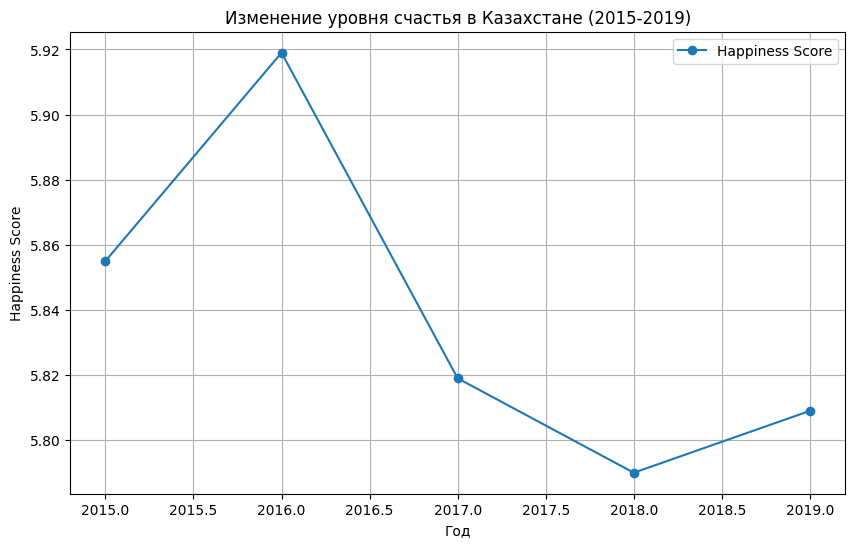

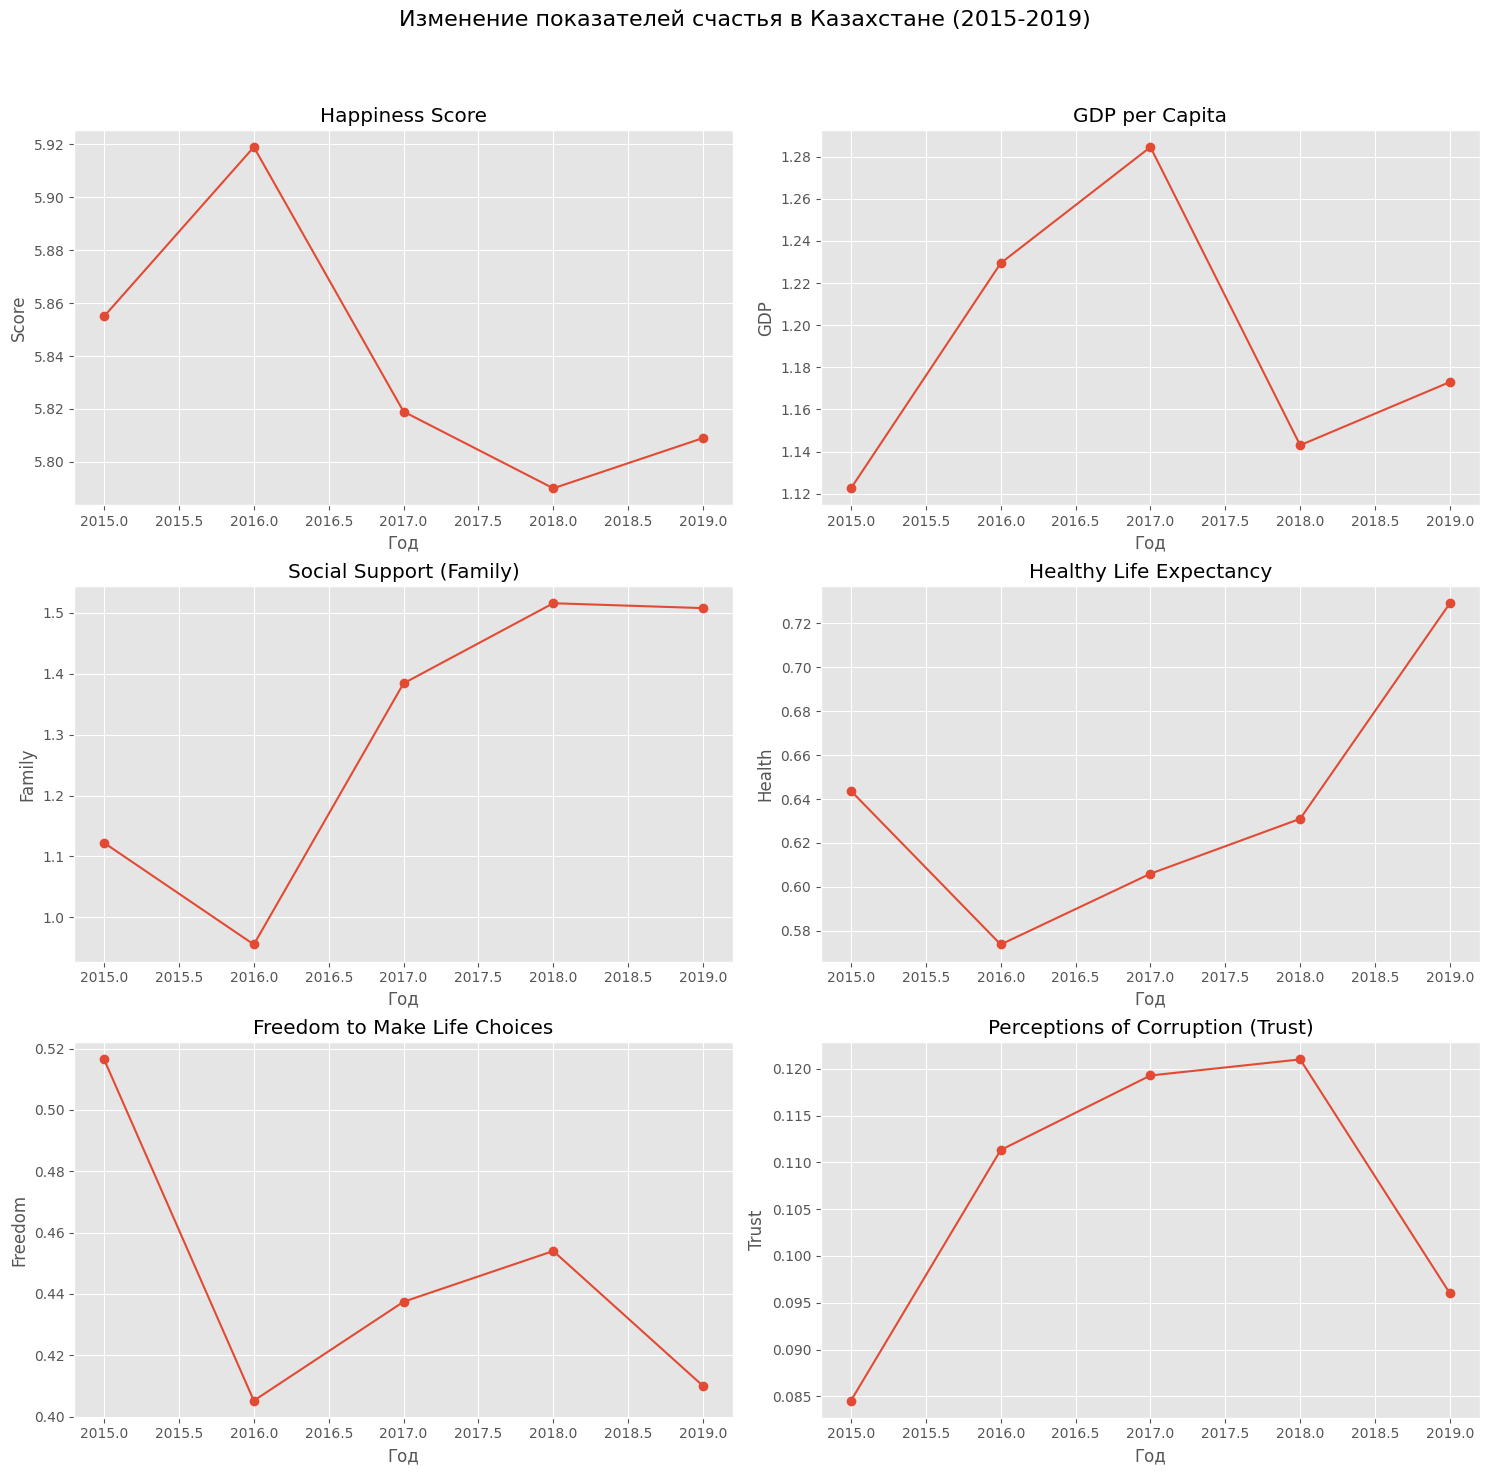

Пропуски в данных: Country       0
Rank          0
Score         0
GDP           0
Family        0
Health        0
Freedom       0
Trust         1
Generosity    0
Year          0
dtype: int64

Типы данных: Country        object
Rank            int64
Score         float64
GDP           float64
Family        float64
Health        float64
Freedom       float64
Trust         float64
Generosity    float64
Year            int64
dtype: object

Статистика данных:              Rank       Score         GDP      Family      Health     Freedom  \
count  782.000000  782.000000  782.000000  782.000000  782.000000  782.000000   
mean    78.698210    5.379018    0.916047    1.078392    0.612416    0.411091   
std     45.182384    1.127456    0.407340    0.329548    0.248309    0.152880   
min      1.000000    2.693000    0.000000    0.000000    0.000000    0.000000   
25%     40.000000    4.509750    0.606500    0.869363    0.440183    0.309768   
50%     79.000000    5.322000    0.982205    1.124735 

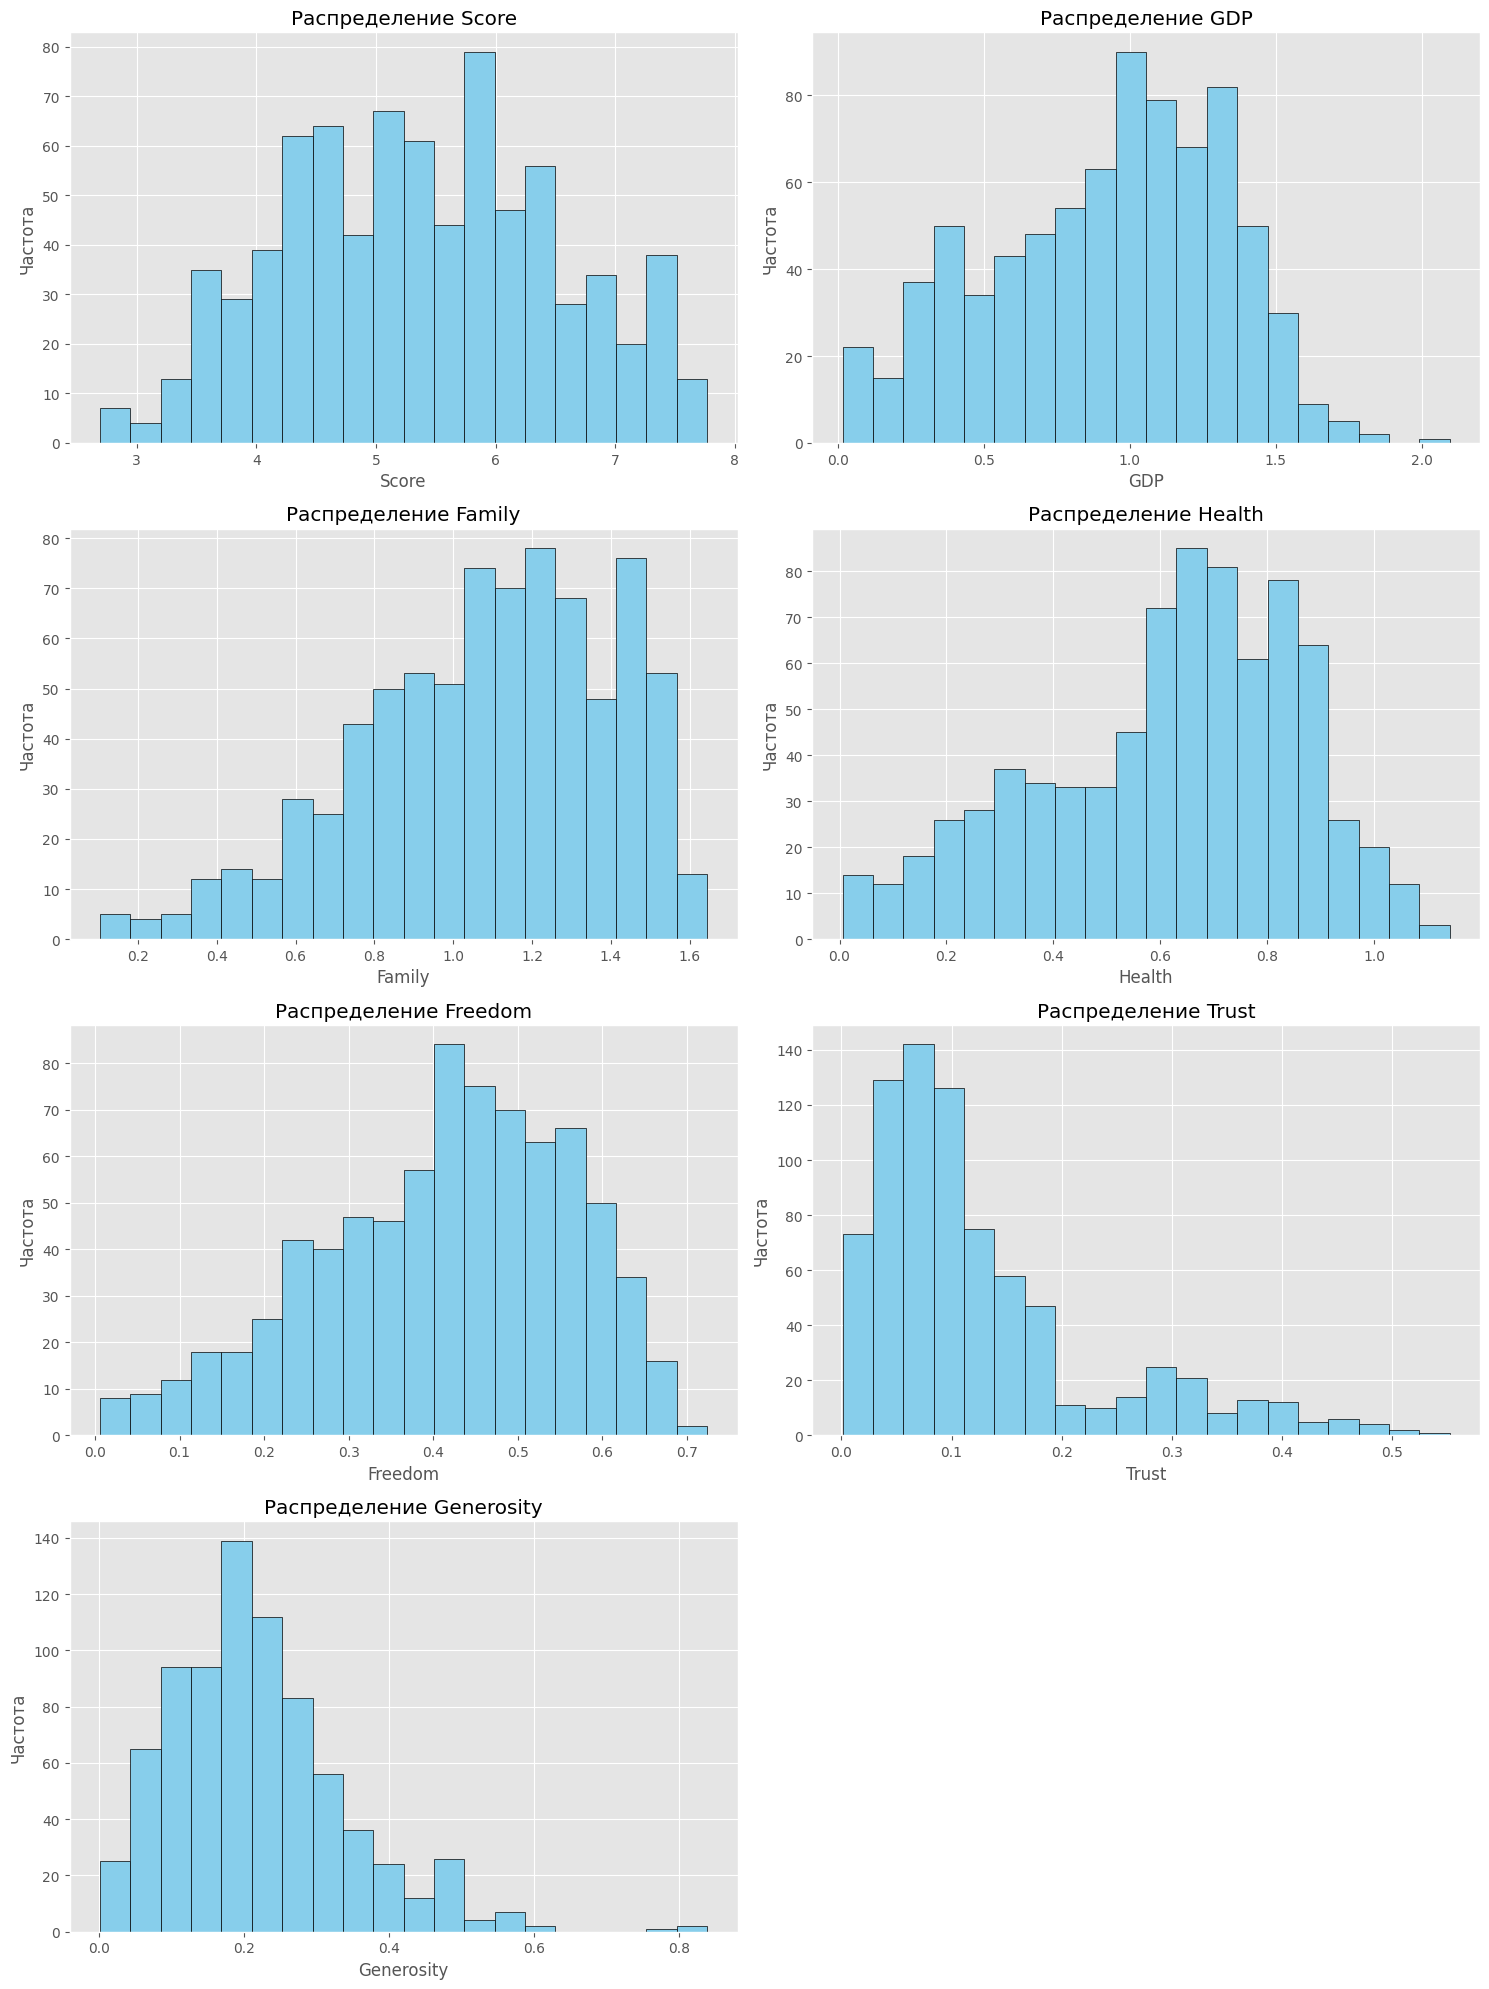

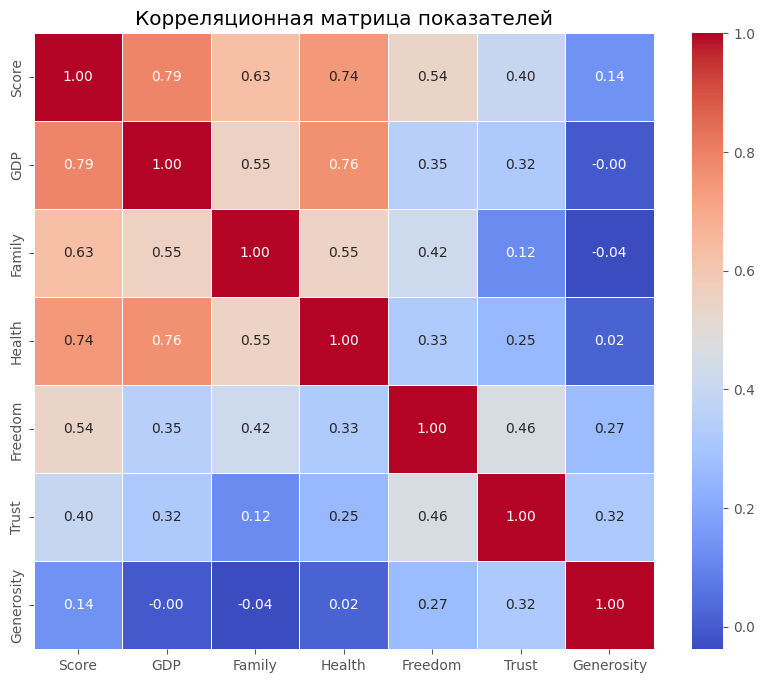

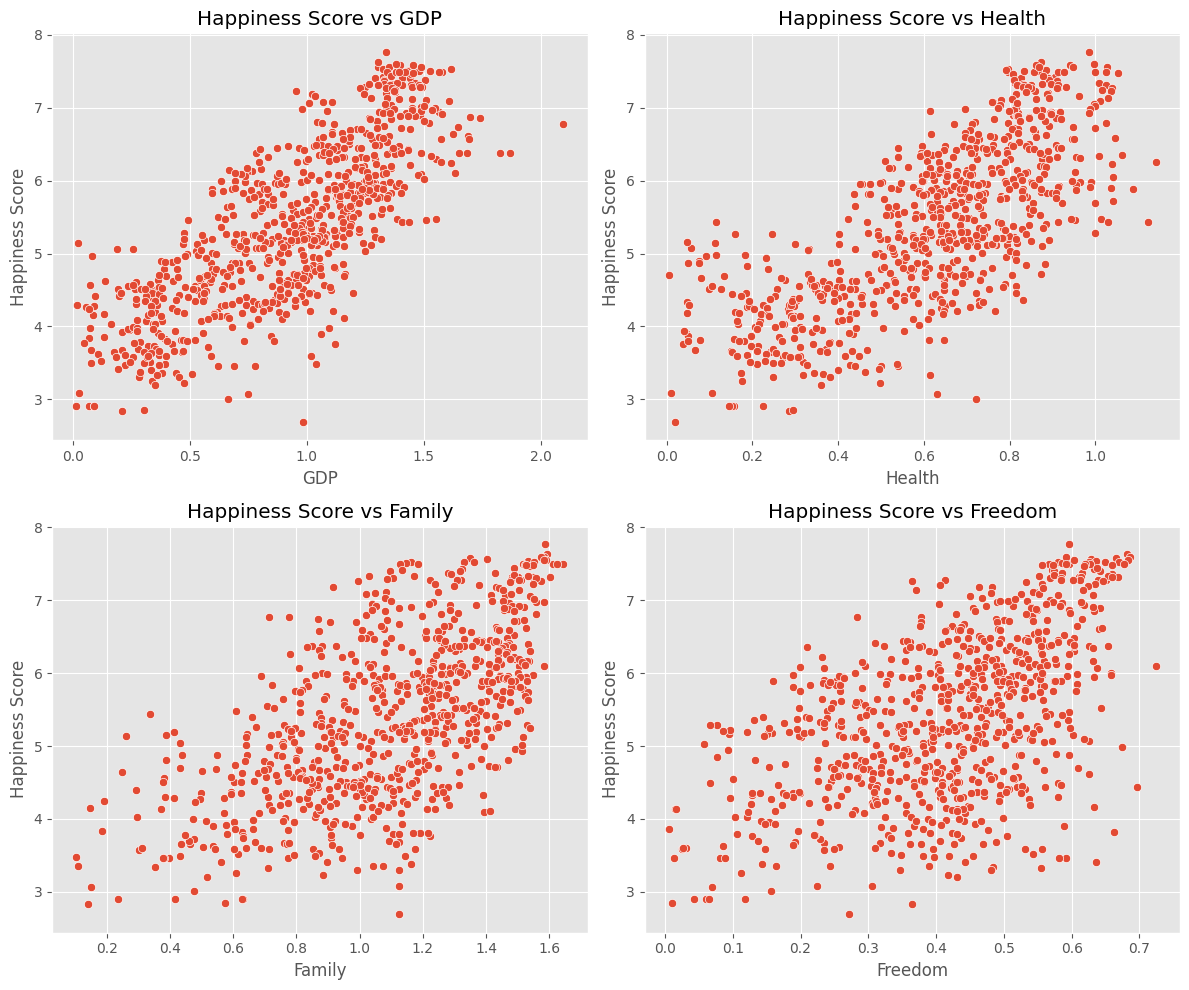

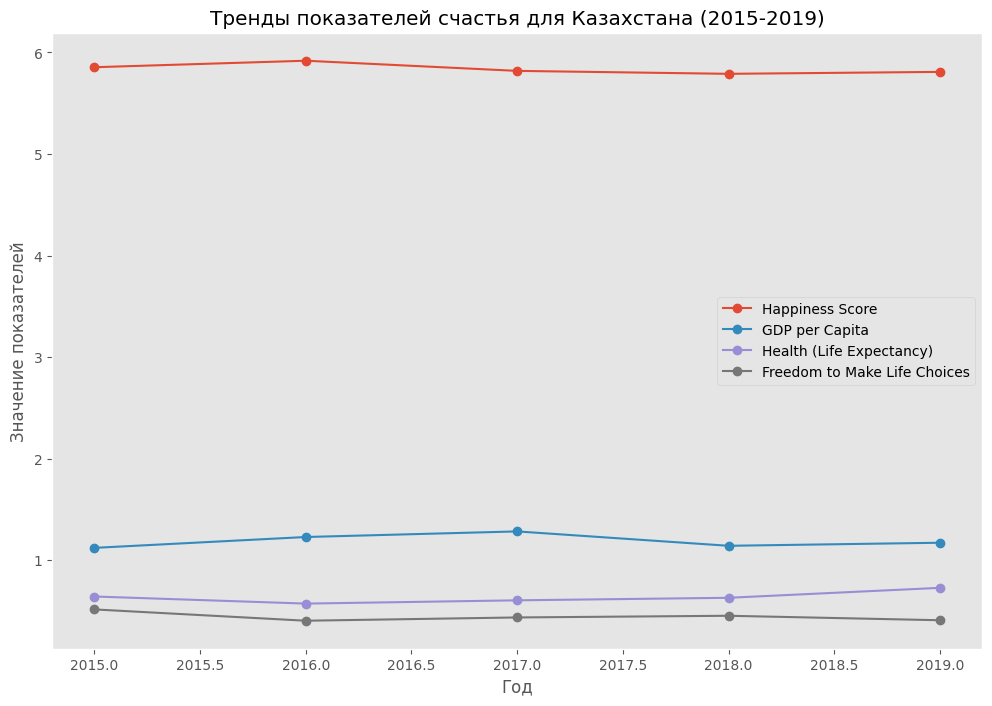

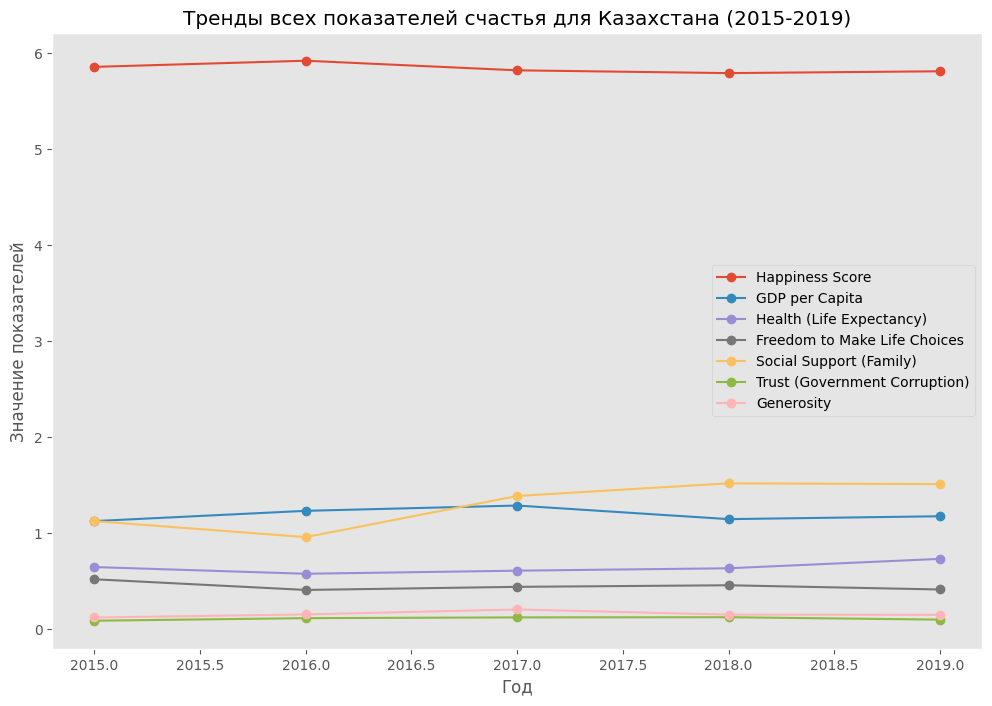

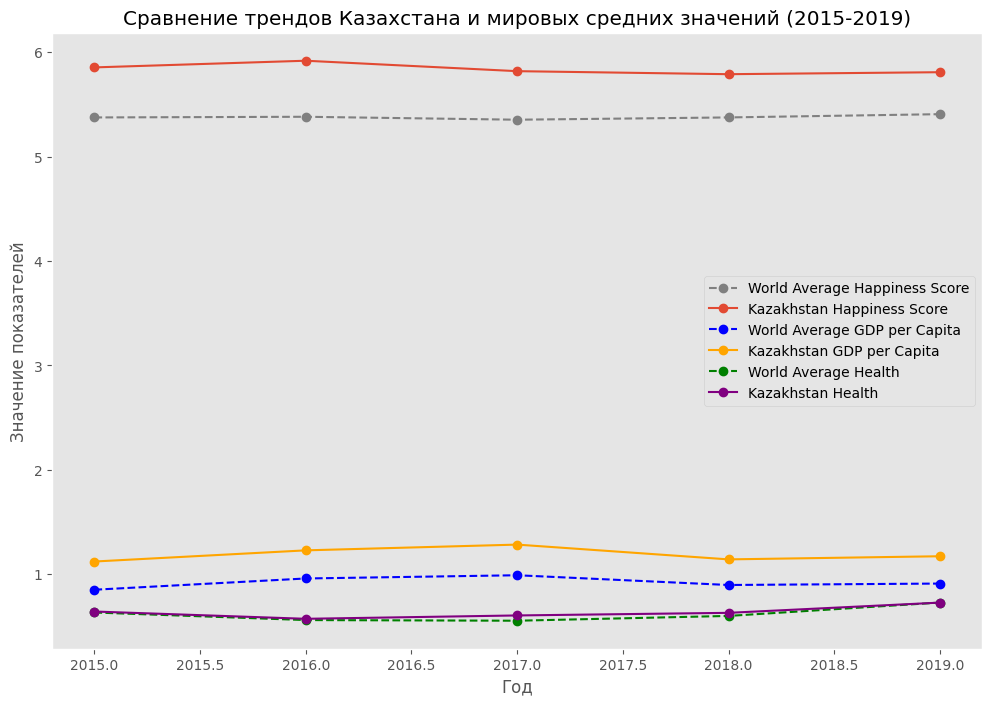

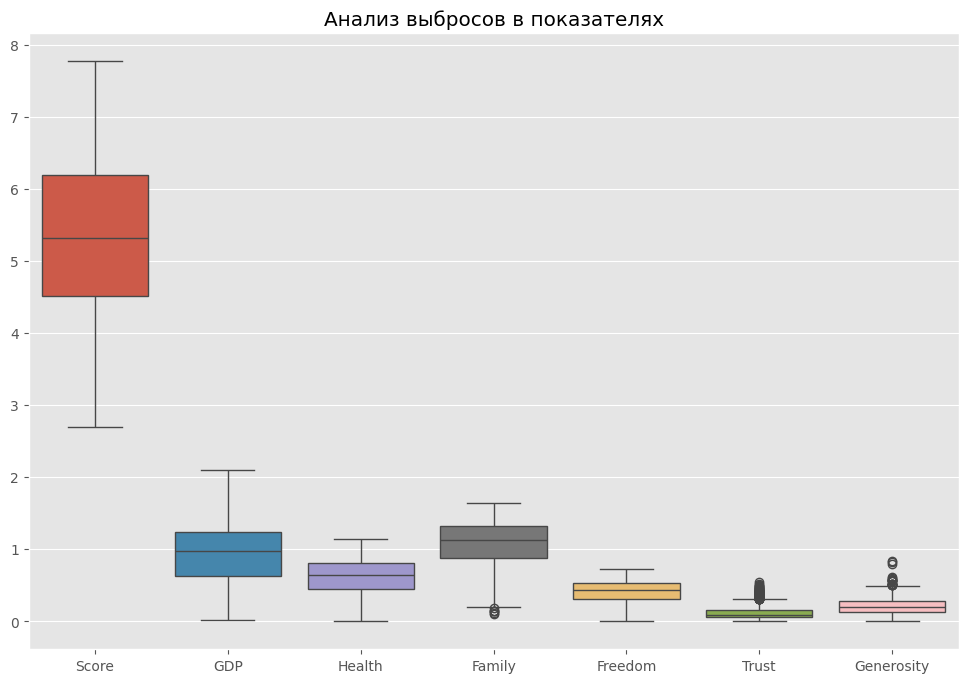

In [1]:
import import_ipynb
from dataPreparation_2015_2019 import combined_df, kazakhstan_data

In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

numeric_df = combined_df.select_dtypes(include=['number'])

correlation_with_target = numeric_df.corr()["Score"].sort_values(ascending=False)
print(correlation_with_target)

threshold = 0.5
selected_features = correlation_with_target[correlation_with_target > threshold].index.tolist()

selected_features.remove("Score")
print("Выбранные признаки для модели:", selected_features)

X = combined_df[selected_features]
y = combined_df["Score"]



Score         1.000000
GDP           0.789617
Health        0.741818
Family        0.627971
Freedom       0.540652
Trust         0.399265
Generosity    0.136859
Year          0.007065
Rank         -0.992066
Name: Score, dtype: float64
Выбранные признаки для модели: ['GDP', 'Health', 'Family', 'Freedom']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print("Проверка стационарности на обучающей выборке:")
result_train = adfuller(y_train)
print("ADF Statistic:", result_train[0])
print("p-value:", result_train[1])

if result_train[1] <= 0.05:
    print("Данные обучающей выборки стационарны.")
else:
    print("Данные обучающей выборки нестационарны. Применим дифференцирование.")


Проверка стационарности на обучающей выборке:
ADF Statistic: -3.7139662241152682
p-value: 0.003920940711350956
Данные обучающей выборки стационарны.


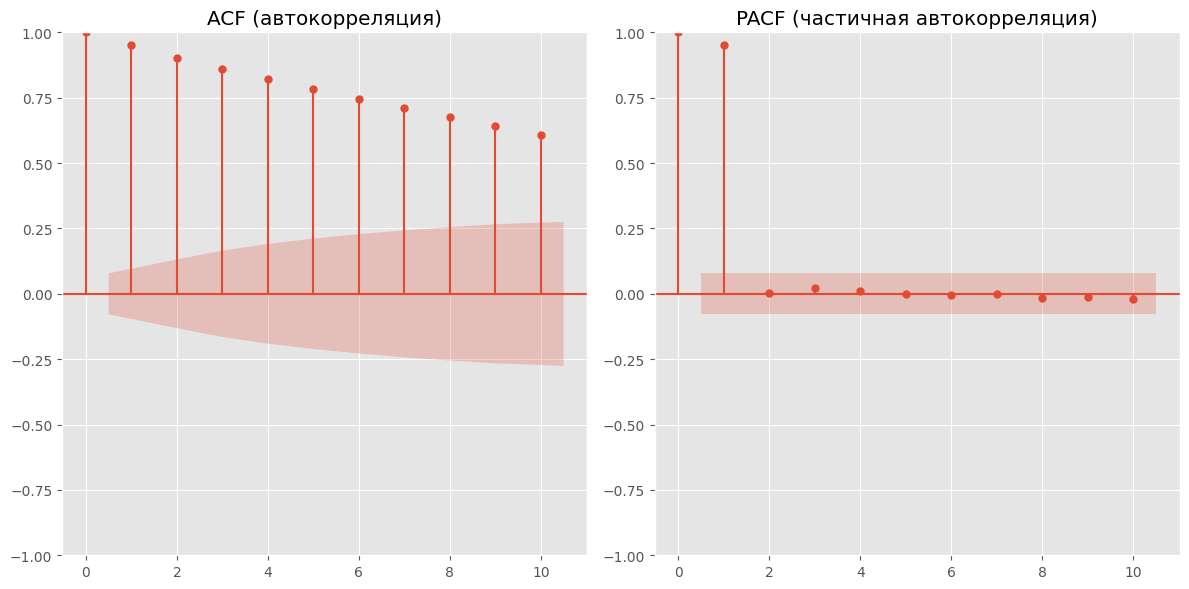

In [4]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
from sklearn.model_selection import train_test_split

data = combined_df[['Year', 'Score']].copy()
data.columns = ['ds', 'y']
data['ds'] = pd.to_datetime(data['ds'], format='%Y')
data.set_index('ds', inplace=True)

X = data[['y']]  # Используем только y для ACF и PACF
y = data['y']

# Построение графиков ACF и PACF на обучающей выборке
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ACF - для определения q
plot_acf(y_train, lags=10, ax=axes[0])
axes[0].set_title('ACF (автокорреляция)')

# PACF - для определения p
plot_pacf(y_train, lags=10, ax=axes[1])
axes[1].set_title('PACF (частичная автокорреляция)')

plt.tight_layout()
plt.show()


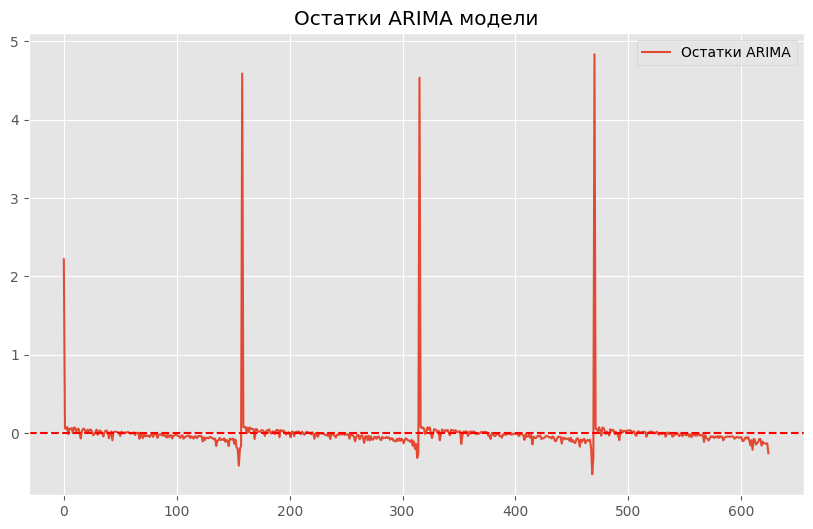

ADF Statistic (остатки): -25.872942248852404
p-value (остатки): 0.0
Остатки стационарны.


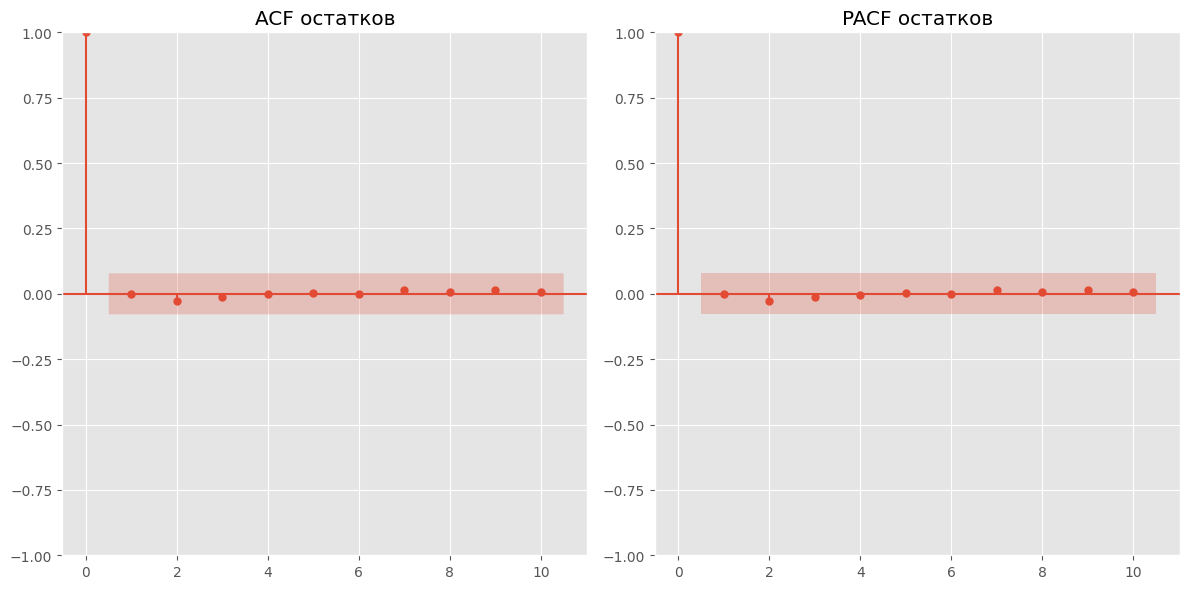

Тест Льюнга-Бокса на автокорреляцию остатков:
     lb_stat  lb_pvalue
10  0.954727   0.999861


In [5]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

model_arima = ARIMA(y_train, order=(1, 0, 1))
model_fit = model_arima.fit()

# Получение остатков модели
residuals = model_fit.resid

# График остатков
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Остатки ARIMA")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Остатки ARIMA модели")
plt.legend()
plt.show()

# Проверка остатков на стационарность
result = adfuller(residuals)
print("ADF Statistic (остатки):", result[0])
print("p-value (остатки):", result[1])

if result[1] <= 0.05:
    print("Остатки стационарны.")
else:
    print("Остатки нестационарны.")

# Графики ACF и PACF остатков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(residuals, lags=10, ax=axes[0])
axes[0].set_title("ACF остатков")
plot_pacf(residuals, lags=10, ax=axes[1])
axes[1].set_title("PACF остатков")
plt.tight_layout()
plt.show()

# Тест Льюнга-Бокса на автокорреляцию остатков
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Тест Льюнга-Бокса на автокорреляцию остатков:")
print(lb_test)


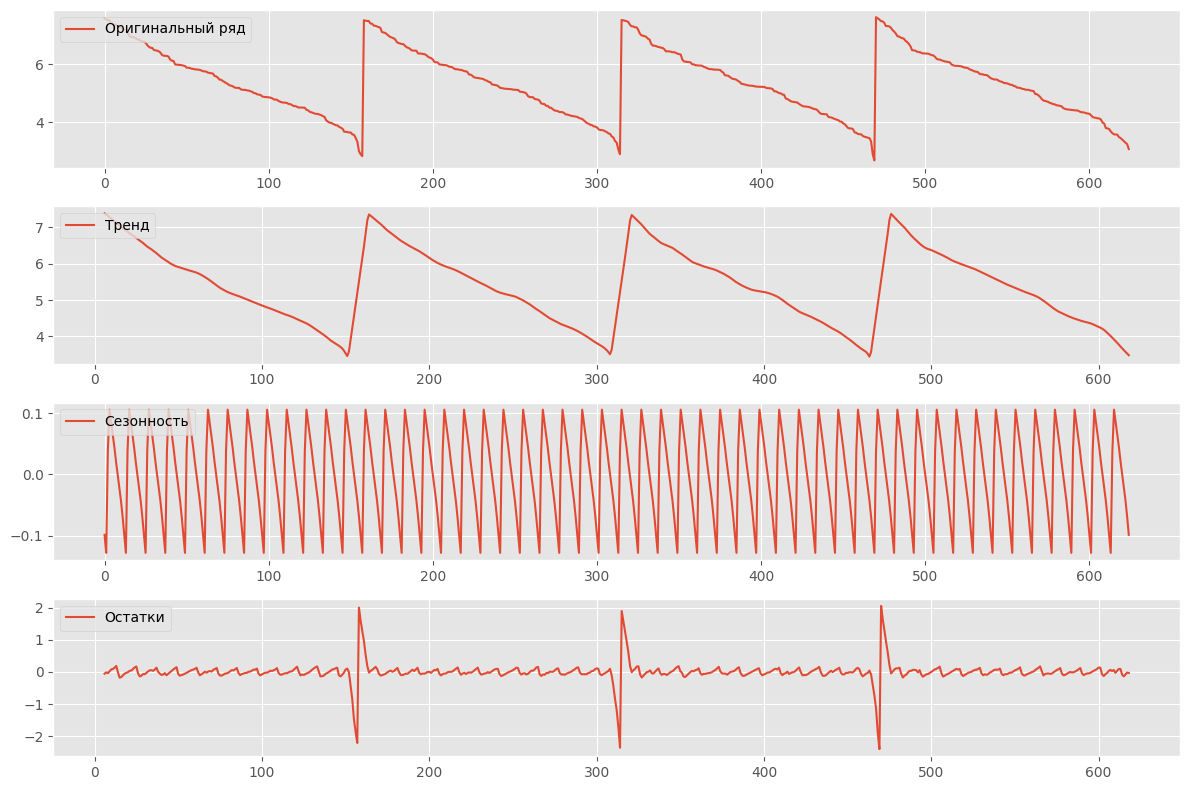

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Разложение временного ряда
decomposition = seasonal_decompose(y_train, model='additive', period=12) 

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(y_train, label='Оригинальный ряд')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Остатки')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


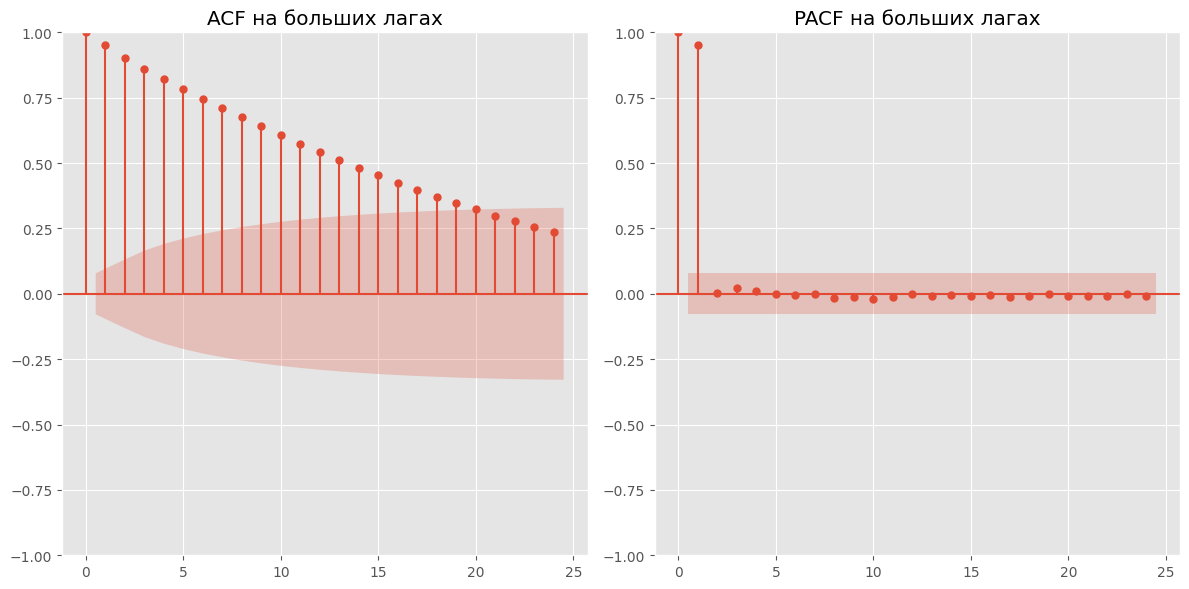

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(y_train, lags=24, ax=axes[0])
axes[0].set_title('ACF на больших лагах')

plot_pacf(y_train, lags=24, ax=axes[1])
axes[1].set_title('PACF на больших лагах')

plt.tight_layout()
plt.show()


In [8]:
combined_df['ds'] = pd.to_datetime(combined_df['Year'], format='%Y')
combined_df = combined_df.sort_values('ds')


In [9]:
common_index = y_train.index.intersection(X_train.index)
y_train_aligned = y_train.loc[common_index]
X_train_aligned = X_train.loc[common_index]


In [10]:
y_train = y_train.sort_index()

In [11]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings("ignore")  # Отключение предупреждений

# Параметры для подбора
p = d = q = range(0, 2)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

best_aic = float("inf")
best_order = None

# Проверка данных
print("Размер y_train:", len(y_train))
if y_train.isnull().sum() > 0:
    print("Пропуски в данных обнаружены. Заполните их перед обучением.")
else:
    print("Пропусков в данных нет.")

for param in itertools.product(p, d, q):
    for seasonal_param in seasonal_pdq:
        try:
            # Создаем модель
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param)
            results = model.fit(method='powell', disp=False)
            
            # Проверяем AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (param, seasonal_param)
                
        except Exception as e:
            print(f"Ошибка для параметров {param}, {seasonal_param}: {e}")
            continue

print("Лучшие параметры:", best_order, "AIC:", best_aic)


Размер y_train: 625
Пропусков в данных нет.
Лучшие параметры: ((1, 1, 1), (0, 0, 0, 12)) AIC: 400.76204013584896


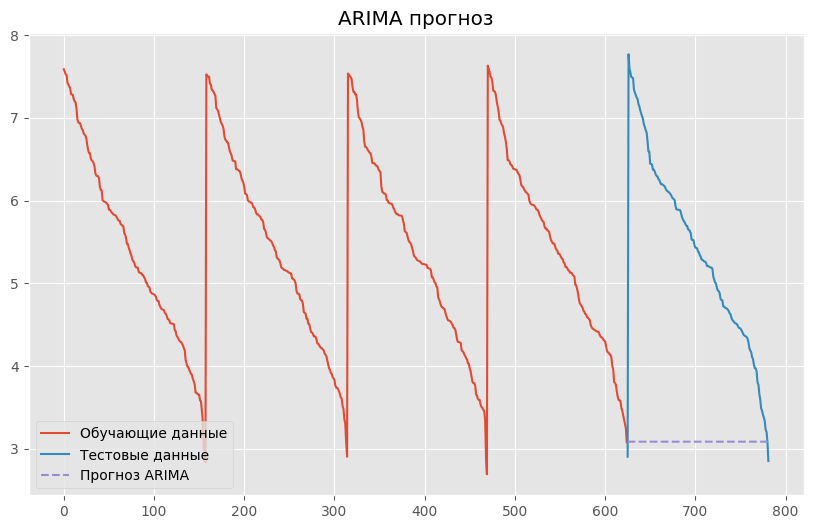

In [12]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(y_train, order=(1, 1, 0)) 
model_fit_arima = model_arima.fit()

pred_arima = model_fit_arima.predict(start=X_test.index[0], end=X_test.index[-1])

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Обучающие данные')
plt.plot(y_test, label='Тестовые данные')
plt.plot(pred_arima, label='Прогноз ARIMA', linestyle='--')
plt.legend()
plt.title('ARIMA прогноз')
plt.show()


In [13]:
for lag in range(1, 4):
    X_train[f'lag_{lag}'] = y_train.shift(lag)
    X_test[f'lag_{lag}'] = y_test.shift(lag)


In [14]:
y_train_smoothed = y_train.rolling(window=5).mean().dropna()


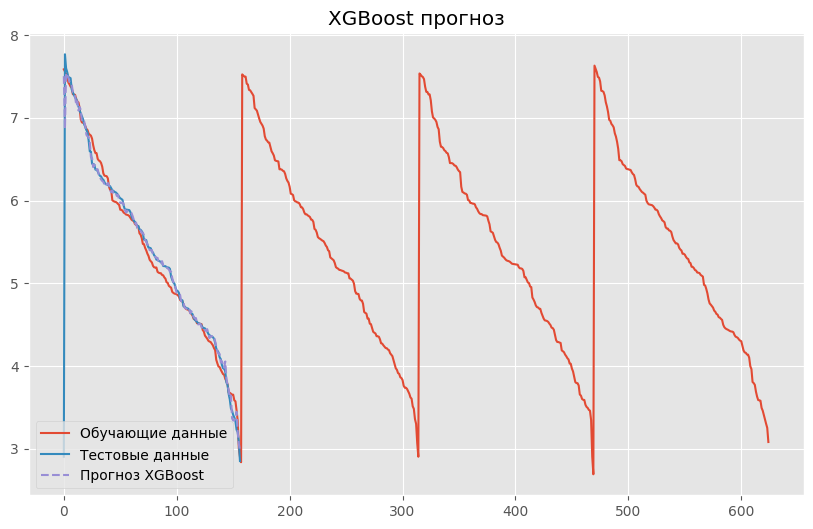

In [15]:
from xgboost import XGBRegressor

X_train_ml, X_test_ml = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train_ml, y_test_ml = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

model_xgb = XGBRegressor()
model_xgb.fit(X_train_ml, y_train_ml)

pred_xgb = model_xgb.predict(X_test_ml)

plt.figure(figsize=(10, 6))
plt.plot(y_train_ml, label='Обучающие данные')
plt.plot(y_test_ml, label='Тестовые данные')
plt.plot(pred_xgb, label='Прогноз XGBoost', linestyle='--')
plt.legend()
plt.title('XGBoost прогноз')
plt.show()


In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_dist, 
    n_iter=10,       
    cv=3,            
    verbose=2, 
    n_jobs=-1        
)

random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print(f"Лучшие параметры: {best_params}")

best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
predictions = best_rf.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Random Forest - MSE: {mse}, R²: {r2}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Лучшие параметры: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
Random Forest - MSE: 0.12776433028879566, R²: 0.8988304736424596


Random Forest - MSE: 0.10780082352323735, R²: 0.9146384735696834


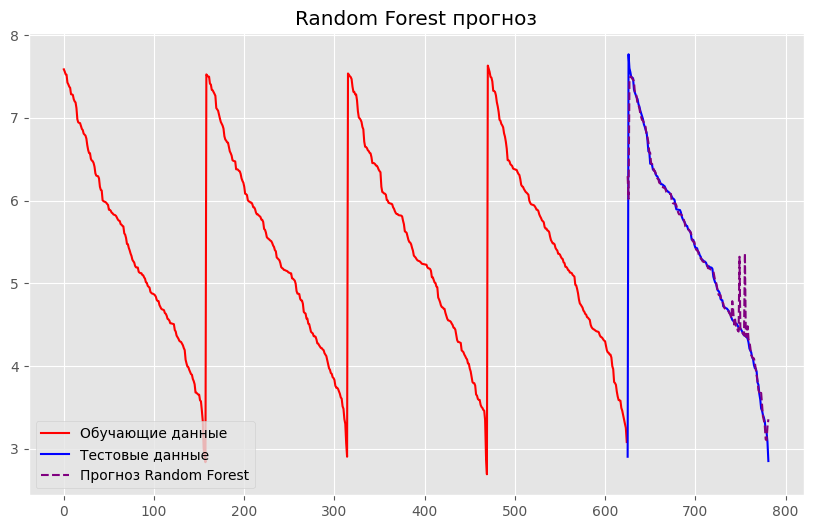

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(n_estimators=50,min_samples_split=5,min_samples_leaf=2, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
print(f"Random Forest - MSE: {rf_mse}, R²: {rf_r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Обучающие данные', color='red')
plt.plot(y_test, label='Тестовые данные', color='blue')
plt.plot(y_test.index, rf_predictions, label='Прогноз Random Forest', linestyle='--', color='purple')
plt.legend()
plt.title('Random Forest прогноз')
plt.show()


In [19]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore") 

lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 3, 5, 7],
    'num_leaves': [20, 30, 40],
    'min_data_in_leaf': [10, 20, 30],
    'lambda_l1': [0.0, 0.01, 0.1],
    'lambda_l2': [0.0, 0.01, 0.1]
}

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    scoring='r2',
    cv=3,
    n_iter=50, 
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Лучшие параметры LightGBM: {best_params}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры LightGBM: {'num_leaves': 20, 'n_estimators': 500, 'min_data_in_leaf': 10, 'max_depth': -1, 'learning_rate': 0.1, 'lambda_l2': 0.1, 'lambda_l1': 0.01}


LightGBM после оптимизации - MSE: 0.15699300014850104, R²: 0.875685902077898


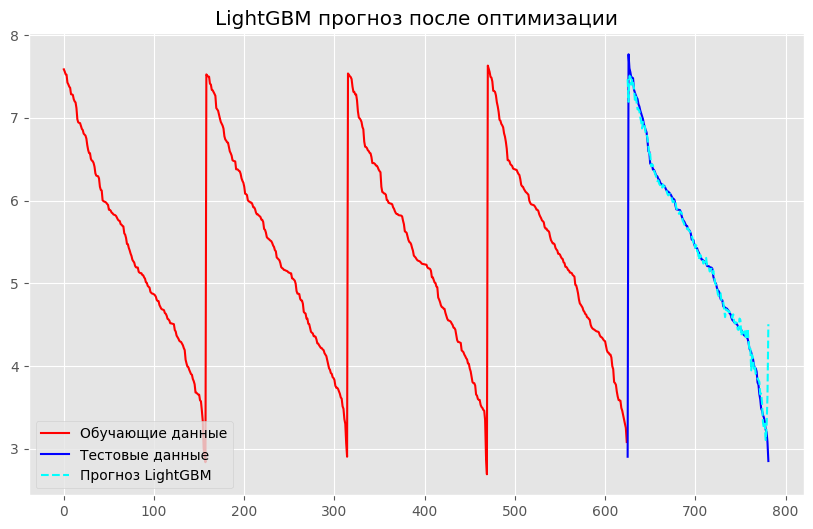

In [20]:
best_lgb_model = lgb.LGBMRegressor(**best_params, verbose=-1, verbosity=-1)
best_lgb_model.fit(X_train, y_train)

lgb_predictions = best_lgb_model.predict(X_test)

lgb_mse = mean_squared_error(y_test, lgb_predictions)
lgb_r2 = r2_score(y_test, lgb_predictions)
print(f"LightGBM после оптимизации - MSE: {lgb_mse}, R²: {lgb_r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Обучающие данные', color='red')
plt.plot(y_test, label='Тестовые данные', color='blue')
plt.plot(y_test.index, lgb_predictions, label='Прогноз LightGBM', linestyle='--', color='cyan')
plt.legend()
plt.title('LightGBM прогноз после оптимизации')
plt.show()


In [21]:
from sklearn.impute import SimpleImputer
import pandas as pd

imputer = SimpleImputer(strategy='mean')  # Strategy can be 'mean', 'median', 'most_frequent', or 'constant'
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())


Linear Regression - MSE: 0.1369000368675791, R²: 0.8915964114795083


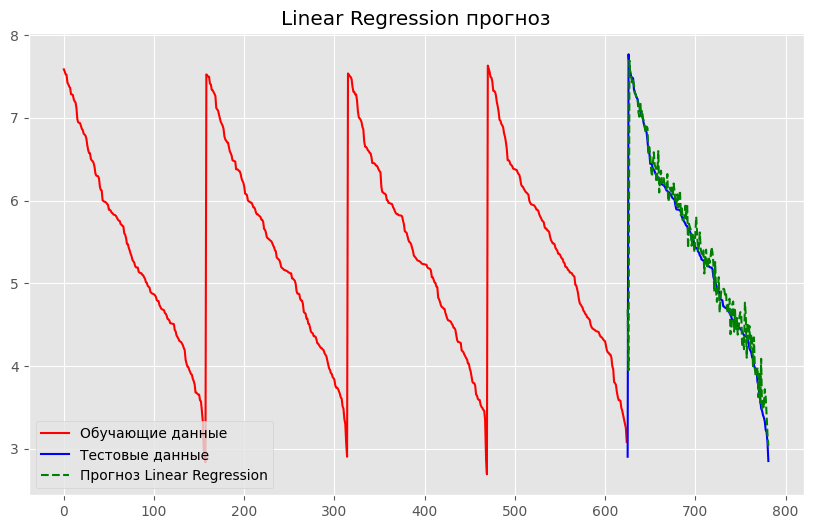

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_predictions = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_predictions)
linear_r2 = r2_score(y_test, linear_predictions)
print(f"Linear Regression - MSE: {linear_mse}, R²: {linear_r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Обучающие данные', color='red')
plt.plot(y_test, label='Тестовые данные', color='blue')
plt.plot(y_test.index, linear_predictions, label='Прогноз Linear Regression', linestyle='--', color='green')
plt.legend()
plt.title('Linear Regression прогноз')
plt.show()


Gradient Boosting - MSE: 0.08201526294765767, R²: 0.9350566367956666


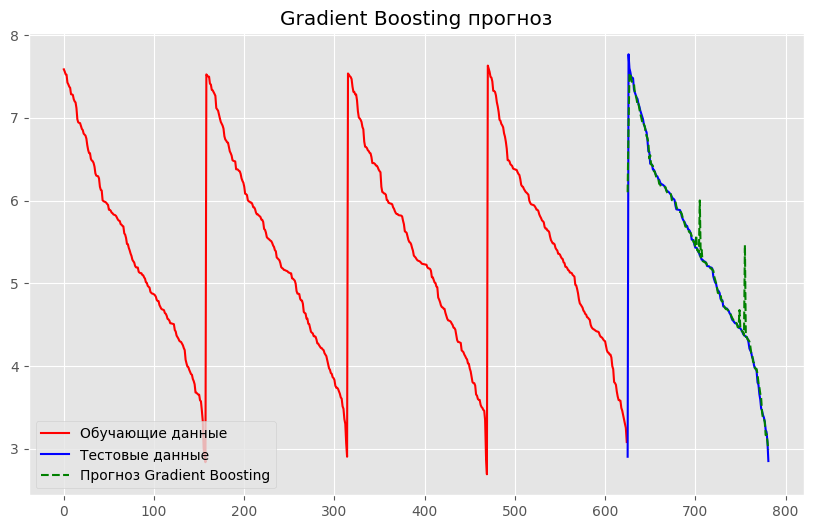

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

gb_predictions = gb_model.predict(X_test)

gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
print(f"Gradient Boosting - MSE: {gb_mse}, R²: {gb_r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Обучающие данные', color='red')
plt.plot(y_test, label='Тестовые данные', color='blue')
plt.plot(y_test.index, gb_predictions, label='Прогноз Gradient Boosting', linestyle='--', color='green')
plt.legend()
plt.title('Gradient Boosting прогноз')
plt.show()


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

print("Количество пропущенных значений в X_train:", X_train.isna().sum().sum())

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_scaled)
X_test_imputed = imputer.transform(X_test_scaled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

param_distributions = {
    'C': uniform(loc=0.1, scale=100),
    'epsilon': uniform(loc=0.01, scale=1),
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

svr_model = SVR()
random_search = RandomizedSearchCV(
    estimator=svr_model,
    param_distributions=param_distributions, 
    n_iter=50, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", random_search.best_params_)

best_svr = random_search.best_estimator_

svr_predictions = best_svr.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, r2_score
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)

print(f"SVR - MSE: {svr_mse}, R²: {svr_r2}")


Количество пропущенных значений в X_train: 0
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'C': 64.86901205413622, 'epsilon': 0.010520376995315819, 'gamma': 0.1}
SVR - MSE: 0.1304541281078858, R²: 0.8967005711044055


In [25]:
for lag in range(1, 4):
    combined_df[f'lag_{lag}'] = combined_df['Score'].shift(lag)

combined_df.dropna(inplace=True)

X = combined_df.drop(['Score'], axis=1)
y = combined_df['Score']

SVR - MSE: 0.1401189528002386, R²: 0.8890475294906481


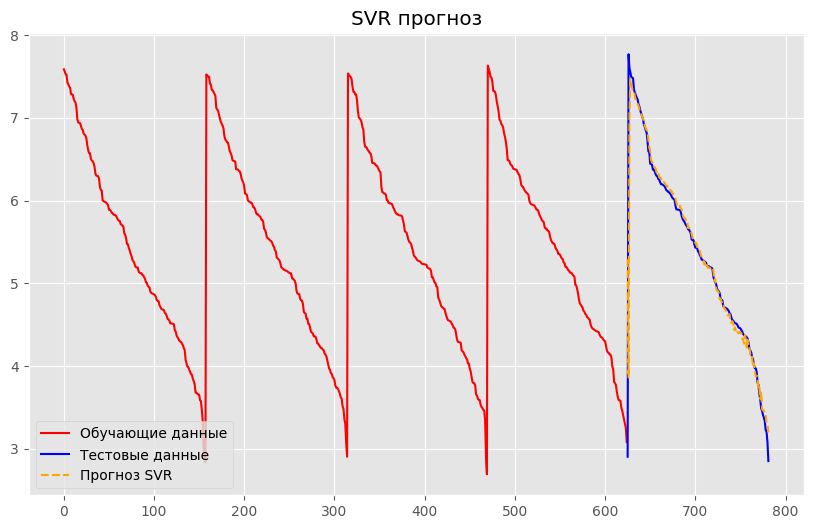

In [26]:
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

svr_predictions = svr_model.predict(X_test)

svr_mse = mean_squared_error(y_test, svr_predictions)
svr_r2 = r2_score(y_test, svr_predictions)
print(f"SVR - MSE: {svr_mse}, R²: {svr_r2}")

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Обучающие данные', color='red')
plt.plot(y_test, label='Тестовые данные', color='blue')
plt.plot(y_test.index, svr_predictions, label='Прогноз SVR', linestyle='--', color='orange')
plt.legend()
plt.title('SVR прогноз')
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # RMSE
    mae = mean_absolute_error(y_true, y_pred)  # MAE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # MAPE
    r2 = r2_score(y_true, y_pred)  # R2
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }

results = []

svr_predictions = best_svr.predict(X_test_scaled)
results.append(calculate_metrics(y_test, svr_predictions, 'SVR'))

gb_predictions = gb_model.predict(X_test)
results.append(calculate_metrics(y_test, gb_predictions, 'Gradient Boosting'))

linear_predictions = linear_model.predict(X_test)
results.append(calculate_metrics(y_test, linear_predictions, 'Linear Regression'))

lgb_predictions = best_lgb_model.predict(X_test)
results.append(calculate_metrics(y_test, lgb_predictions, 'LightGBM'))

rf_predictions = rf_model.predict(X_test)
results.append(calculate_metrics(y_test, rf_predictions, 'Random Forest'))

pred_xgb = model_xgb.predict(X_test.reset_index(drop=True))
results.append(calculate_metrics(y_test.reset_index(drop=True), pred_xgb, 'XGBoost'))

pred_arima = model_fit_arima.predict(start=X_test.index[0], end=X_test.index[-1])
results.append(calculate_metrics(y_test, pred_arima, 'ARIMA'))

sarima_predictions = model_fit.predict(start=X_test.index[0], end=X_test.index[-1], exog=X_test)
results.append(calculate_metrics(y_test, sarima_predictions, 'SARIMA'))

metrics_df = pd.DataFrame(results)
print(metrics_df)


               Model       MSE      RMSE       MAE      MAPE        R²
0                SVR  0.130454  0.361184  0.076166  1.602329  0.896701
1  Gradient Boosting  0.082015  0.286383  0.063789  1.544311  0.935057
2  Linear Regression  0.136900  0.370000  0.155202  3.201589  0.891596
3           LightGBM  0.075555  0.274872  0.079206  1.936070  0.940173
4      Random Forest  0.077315  0.278055  0.076199  1.754690  0.938779
5            XGBoost  0.043697  0.209037  0.050270  1.193481  0.965399
6              ARIMA  0.066976  0.258798  0.106259       NaN  0.946965
7             SARIMA  0.052975  0.230162  0.105164       NaN  0.958052


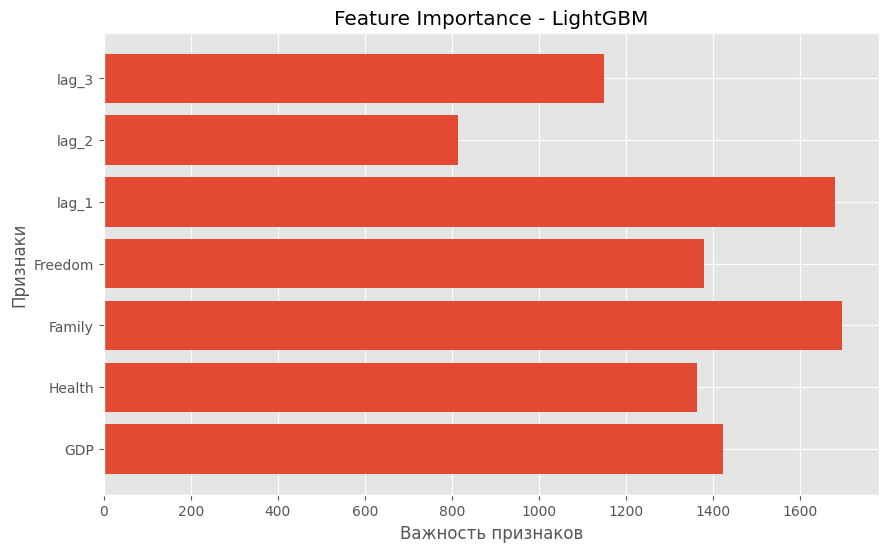

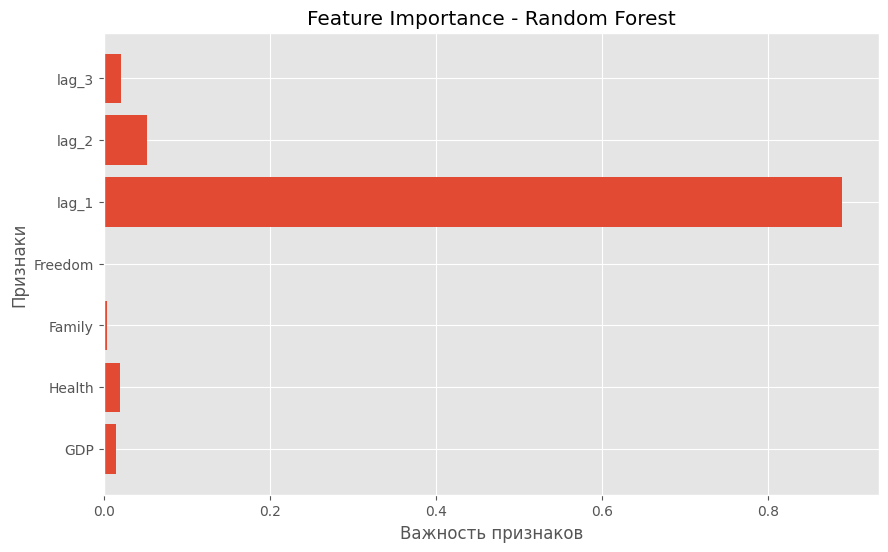

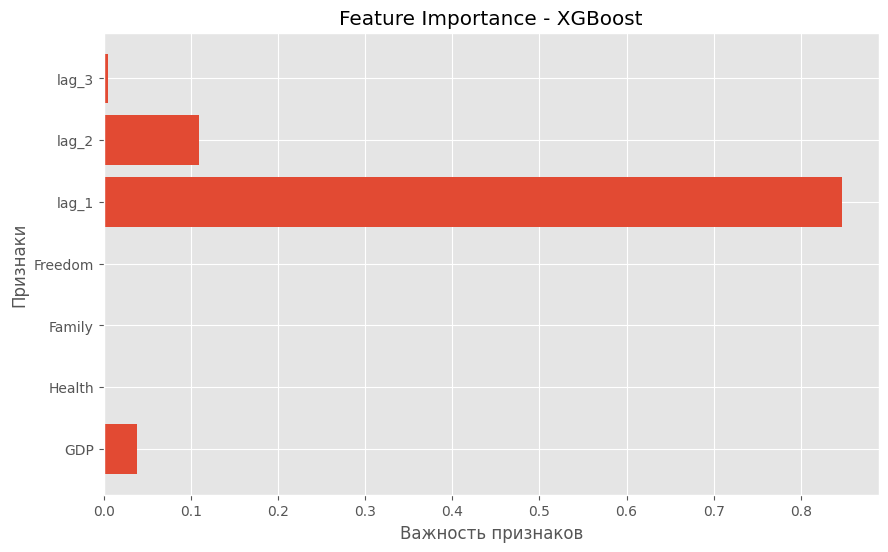

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lgb_importance = best_lgb_model.feature_importances_
plt.barh(X_train.columns, lgb_importance)
plt.title('Feature Importance - LightGBM')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()

plt.figure(figsize=(10, 6))
rf_importance = rf_model.feature_importances_
plt.barh(X_train.columns, rf_importance)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()

plt.figure(figsize=(10, 6))
xgb_importance = model_xgb.feature_importances_
plt.barh(X_train.columns, xgb_importance)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.show()


In [29]:
imputer = SimpleImputer(strategy='mean')  # Strategy can be 'mean', 'median', 'most_frequent', or 'constant'
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

y_train = y_train.fillna(y_train.mean())
y_test = y_test.fillna(y_test.mean())

In [30]:
last_known_date = combined_df['ds'].max()

future_dates = pd.date_range(start=last_known_date + pd.DateOffset(years=1), periods=2, freq='Y')

print(future_dates)

DatetimeIndex(['2020-12-31', '2021-12-31'], dtype='datetime64[ns]', freq='YE-DEC')


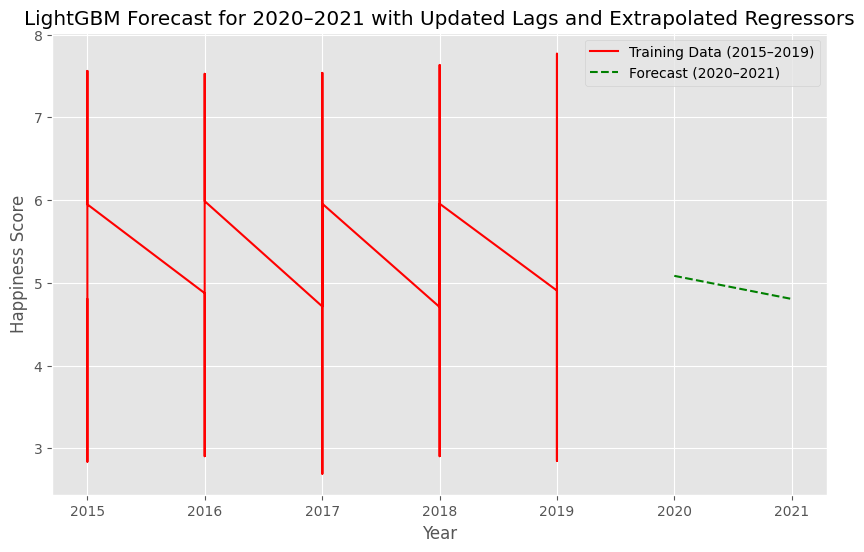

In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

train_data = combined_df[combined_df['ds'].dt.year <= 2019]

X_train = train_data[['GDP', 'Health', 'Family', 'Freedom', 'lag_1', 'lag_2', 'lag_3']].dropna()
y_train = train_data.loc[X_train.index, 'Score']

params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
train_dataset = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_dataset)

last_row = train_data.iloc[-1]
last_known_score = last_row['Score']

future_years = [2020, 2021]
future_ds = pd.to_datetime([f"{year}-01-01" for year in future_years])

def extrapolate_linear(df, feature):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    
    return lin_model.predict([[2020], [2021]])

future_regressors = pd.DataFrame({'ds': future_ds})
future_regressors['GDP'] = extrapolate_linear(train_data, 'GDP')
future_regressors['Health'] = extrapolate_linear(train_data, 'Health')
future_regressors['Family'] = extrapolate_linear(train_data, 'Family')
future_regressors['Freedom'] = extrapolate_linear(train_data, 'Freedom')

lag_1_2020 = last_row['Score']
lag_2_2020 = last_row['lag_1']
lag_3_2020 = last_row['lag_2']

X_2020 = pd.DataFrame({
    'GDP': [future_regressors.loc[0, 'GDP']],
    'Health': [future_regressors.loc[0, 'Health']],
    'Family': [future_regressors.loc[0, 'Family']],
    'Freedom': [future_regressors.loc[0, 'Freedom']],
    'lag_1': [lag_1_2020],
    'lag_2': [lag_2_2020],
    'lag_3': [lag_3_2020]
})

pred_2020 = model.predict(X_2020)[0]

lag_1_2021 = pred_2020
lag_2_2021 = lag_1_2020
lag_3_2021 = lag_2_2020

X_2021 = pd.DataFrame({
    'GDP': [future_regressors.loc[1, 'GDP']],
    'Health': [future_regressors.loc[1, 'Health']],
    'Family': [future_regressors.loc[1, 'Family']],
    'Freedom': [future_regressors.loc[1, 'Freedom']],
    'lag_1': [lag_1_2021],
    'lag_2': [lag_2_2021],
    'lag_3': [lag_3_2021]
})

pred_2021 = model.predict(X_2021)[0]

plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['Score'], label='Training Data (2015–2019)', color='red')
plt.plot(future_regressors['ds'], [pred_2020, pred_2021], label='Forecast (2020–2021)', linestyle='--', color='green')

plt.title('LightGBM Forecast for 2020–2021 with Updated Lags and Extrapolated Regressors')
plt.xlabel('Year')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
print(combined_df.head())

                     Country  Rank  Score      GDP   Family   Health  Freedom  \
103                  Hungary   104  4.800  1.12094  1.20215  0.75905  0.32112   
104                 Honduras   105  4.788  0.59532  0.95348  0.69510  0.40148   
105               Tajikistan   106  4.786  0.39047  0.85563  0.57379  0.47216   
106                  Tunisia   107  4.739  0.88113  0.60429  0.73793  0.26268   
107  Palestinian Territories   108  4.715  0.59867  0.92558  0.66015  0.24499   

       Trust  Generosity  Year         ds  lag_1  lag_2  lag_3  
103  0.02758     0.12800  2015 2015-01-01  4.839  4.857  7.587  
104  0.06825     0.23027  2015 2015-01-01  4.800  4.839  4.857  
105  0.15072     0.22974  2015 2015-01-01  4.788  4.800  4.839  
106  0.06358     0.06431  2015 2015-01-01  4.786  4.788  4.800  
107  0.12905     0.11251  2015 2015-01-01  4.739  4.786  4.788  


In [33]:
combined_df['ds'].dtype

dtype('<M8[ns]')

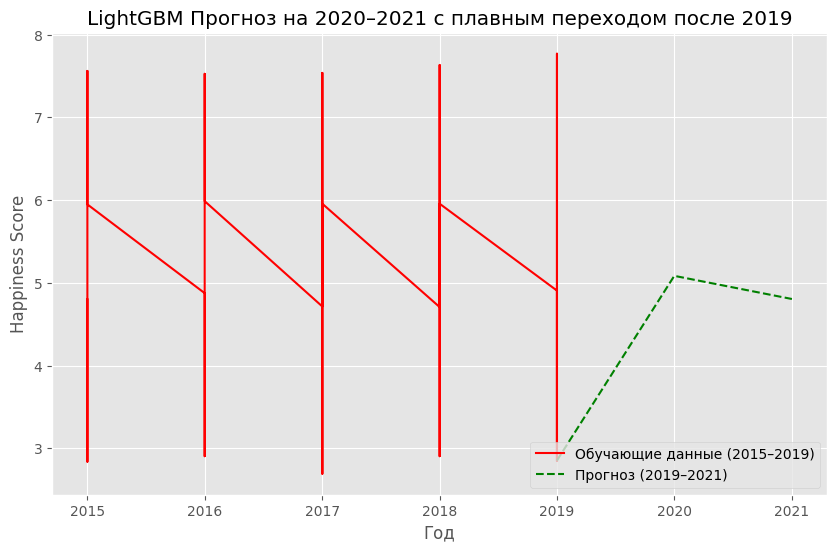

In [34]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

train_data = combined_df[combined_df['ds'].dt.year <= 2019]

X_train = train_data[['GDP', 'Health', 'Family', 'Freedom', 'lag_1', 'lag_2', 'lag_3']].dropna()
y_train = train_data.loc[X_train.index, 'Score']

params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
train_dataset = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_dataset)

last_row = train_data.iloc[-1]
last_known_score = last_row['Score']

future_years = [2020, 2021]
future_ds = pd.to_datetime([f"{year}-01-01" for year in future_years])

def extrapolate_linear(df, feature):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    return lin_model.predict([[2020], [2021]])

future_regressors = pd.DataFrame({'ds': future_ds})
future_regressors['GDP'] = extrapolate_linear(train_data, 'GDP')
future_regressors['Health'] = extrapolate_linear(train_data, 'Health')
future_regressors['Family'] = extrapolate_linear(train_data, 'Family')
future_regressors['Freedom'] = extrapolate_linear(train_data, 'Freedom')

# Лаги для 2020
lag_1_2020 = last_row['Score']
lag_2_2020 = last_row['lag_1']
lag_3_2020 = last_row['lag_2']

X_2020 = pd.DataFrame({
    'GDP': [future_regressors.loc[0, 'GDP']],
    'Health': [future_regressors.loc[0, 'Health']],
    'Family': [future_regressors.loc[0, 'Family']],
    'Freedom': [future_regressors.loc[0, 'Freedom']],
    'lag_1': [lag_1_2020],
    'lag_2': [lag_2_2020],
    'lag_3': [lag_3_2020]
})
pred_2020 = model.predict(X_2020)[0]

# Лаги для 2021
lag_1_2021 = pred_2020
lag_2_2021 = lag_1_2020
lag_3_2021 = lag_2_2020

X_2021 = pd.DataFrame({
    'GDP': [future_regressors.loc[1, 'GDP']],
    'Health': [future_regressors.loc[1, 'Health']],
    'Family': [future_regressors.loc[1, 'Family']],
    'Freedom': [future_regressors.loc[1, 'Freedom']],
    'lag_1': [lag_1_2021],
    'lag_2': [lag_2_2021],
    'lag_3': [lag_3_2021]
})
pred_2021 = model.predict(X_2021)[0]

smooth_df = pd.DataFrame({
    'ds': [pd.Timestamp('2019-01-01'), future_ds[0], future_ds[1]],
    'Score': [last_known_score, pred_2020, pred_2021]
})

plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['Score'], label='Обучающие данные (2015–2019)', color='red')
plt.plot(smooth_df['ds'], smooth_df['Score'], label='Прогноз (2019–2021)', linestyle='--', color='green')

plt.title('LightGBM Прогноз на 2020–2021 с плавным переходом после 2019')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
train_data = train_data.sort_values('ds')

In [36]:
train_data = combined_df[combined_df['Country'] == 'Kazakhstan'].copy()
train_data = train_data[train_data['ds'].dt.year <= 2019]
train_data = train_data.sort_values('ds')


In [37]:
print(train_data['ds'].value_counts())


ds
2015-01-01    1
2016-01-01    1
2017-01-01    1
2018-01-01    1
2019-01-01    1
Name: count, dtype: int64


In [38]:
train_data['lag_1'] = train_data['Score'].shift(1)
train_data['lag_2'] = train_data['Score'].shift(2)
train_data['lag_3'] = train_data['Score'].shift(3)


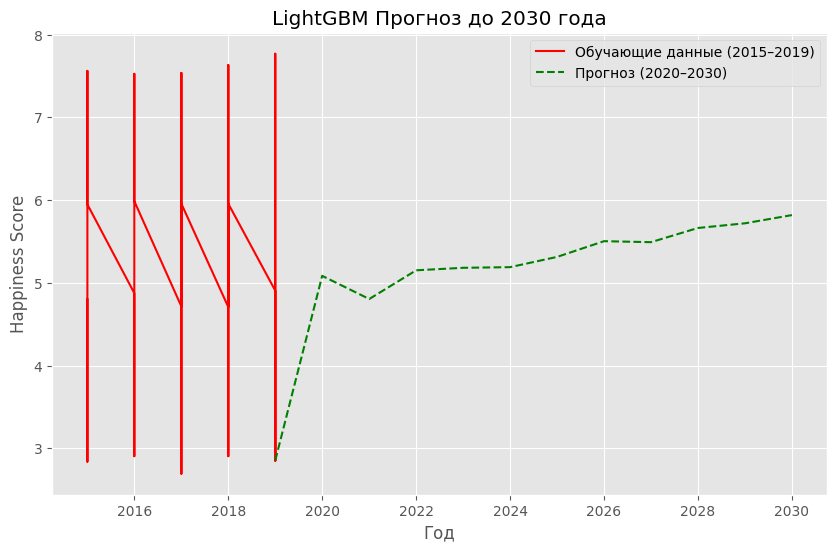

In [39]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

train_data = combined_df[combined_df['ds'].dt.year <= 2019]
X_train = train_data[['GDP', 'Health', 'Family', 'Freedom', 'lag_1', 'lag_2', 'lag_3']].dropna()
y_train = train_data.loc[X_train.index, 'Score']

params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
train_dataset = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_dataset)

last_row = train_data.iloc[-1]
last_known_score = last_row['Score']

def extrapolate_linear(df, feature, future_years):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    # Предсказываем для всех future_years
    future_X = np.array(future_years).reshape(-1, 1)
    return lin_model.predict(future_X)

future_years = range(2020, 2031)  # 2020 до 2030 включительно
future_ds = pd.to_datetime([f"{year}-01-01" for year in future_years])

future_regressors = pd.DataFrame({'ds': future_ds})
future_regressors['GDP'] = extrapolate_linear(train_data, 'GDP', future_years)
future_regressors['Health'] = extrapolate_linear(train_data, 'Health', future_years)
future_regressors['Family'] = extrapolate_linear(train_data, 'Family', future_years)
future_regressors['Freedom'] = extrapolate_linear(train_data, 'Freedom', future_years)

lag_1 = last_row['Score']
lag_2 = last_row['lag_1']
lag_3 = last_row['lag_2']

predictions = []
pred_years = []
current_lag_1 = lag_1
current_lag_2 = lag_2
current_lag_3 = lag_3

for i, year in enumerate(future_years):
    row = future_regressors.iloc[i]
    X_future = pd.DataFrame({
        'GDP': [row['GDP']],
        'Health': [row['Health']],
        'Family': [row['Family']],
        'Freedom': [row['Freedom']],
        'lag_1': [current_lag_1],
        'lag_2': [current_lag_2],
        'lag_3': [current_lag_3]
    })
    
    pred = model.predict(X_future)[0]
    predictions.append(pred)
    pred_years.append(year)
    
    current_lag_1, current_lag_2, current_lag_3 = pred, current_lag_1, current_lag_2

smooth_df = pd.DataFrame({
    'ds': [pd.Timestamp('2019-01-01')] + list(future_ds),
    'Score': [last_known_score] + predictions
})

plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['Score'], label='Обучающие данные (2015–2019)', color='red')
plt.plot(smooth_df['ds'], smooth_df['Score'], label='Прогноз (2020–2030)', linestyle='--', color='green')

plt.title('LightGBM Прогноз до 2030 года')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


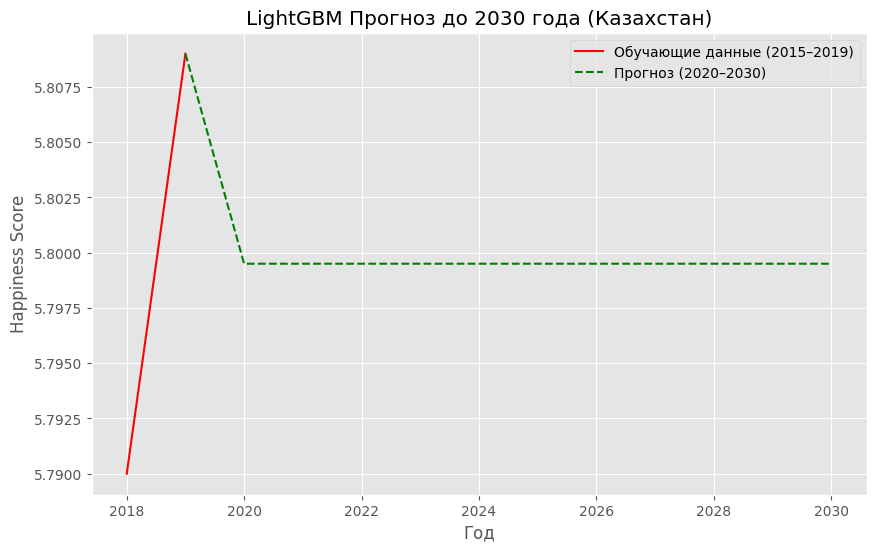

In [40]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

combined_df = combined_df[combined_df['Country'] == 'Kazakhstan'].copy()

combined_df = combined_df.sort_values('ds')

combined_df['lag_1'] = combined_df['Score'].shift(1)
combined_df['lag_2'] = combined_df['Score'].shift(2)
combined_df['lag_3'] = combined_df['Score'].shift(3)

train_data = combined_df[combined_df['ds'].dt.year <= 2019]

train_data = train_data.dropna(subset=['lag_1', 'lag_2', 'lag_3'])

X_train = train_data[['GDP', 'Health', 'Family', 'Freedom', 'lag_1', 'lag_2', 'lag_3']]
y_train = train_data['Score']

params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
train_dataset = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_dataset)

last_row = train_data.iloc[-1]
last_known_score = last_row['Score']

def extrapolate_linear(df, feature, future_years):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    lin_model = LinearRegression()
    lin_model.fit(X, y)
    future_X = np.array(future_years).reshape(-1, 1)
    return lin_model.predict(future_X)

future_years = range(2020, 2031) 
future_ds = pd.to_datetime([f"{year}-01-01" for year in future_years])

future_regressors = pd.DataFrame({'ds': future_ds})
future_regressors['GDP'] = extrapolate_linear(train_data, 'GDP', future_years)
future_regressors['Health'] = extrapolate_linear(train_data, 'Health', future_years)
future_regressors['Family'] = extrapolate_linear(train_data, 'Family', future_years)
future_regressors['Freedom'] = extrapolate_linear(train_data, 'Freedom', future_years)

lag_1 = last_row['Score']
lag_2 = last_row['lag_1']
lag_3 = last_row['lag_2']

predictions = []
pred_years = []
current_lag_1 = lag_1
current_lag_2 = lag_2
current_lag_3 = lag_3

for i, year in enumerate(future_years):
    row = future_regressors.iloc[i]
    X_future = pd.DataFrame({
        'GDP': [row['GDP']],
        'Health': [row['Health']],
        'Family': [row['Family']],
        'Freedom': [row['Freedom']],
        'lag_1': [current_lag_1],
        'lag_2': [current_lag_2],
        'lag_3': [current_lag_3]
    })

    X_future = X_future.astype(float)  # Убедимся в типах

    pred = model.predict(X_future)[0]
    predictions.append(pred)
    pred_years.append(year)

    # Обновляем лаги
    current_lag_1, current_lag_2, current_lag_3 = pred, current_lag_1, current_lag_2

smooth_df = pd.DataFrame({
    'ds': [pd.Timestamp('2019-01-01')] + list(future_ds),
    'Score': [last_known_score] + predictions
})

plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['Score'], label='Обучающие данные (2015–2019)', color='red')
plt.plot(smooth_df['ds'], smooth_df['Score'], label='Прогноз (2020–2030)', linestyle='--', color='green')

plt.title('LightGBM Прогноз до 2030 года (Казахстан)')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


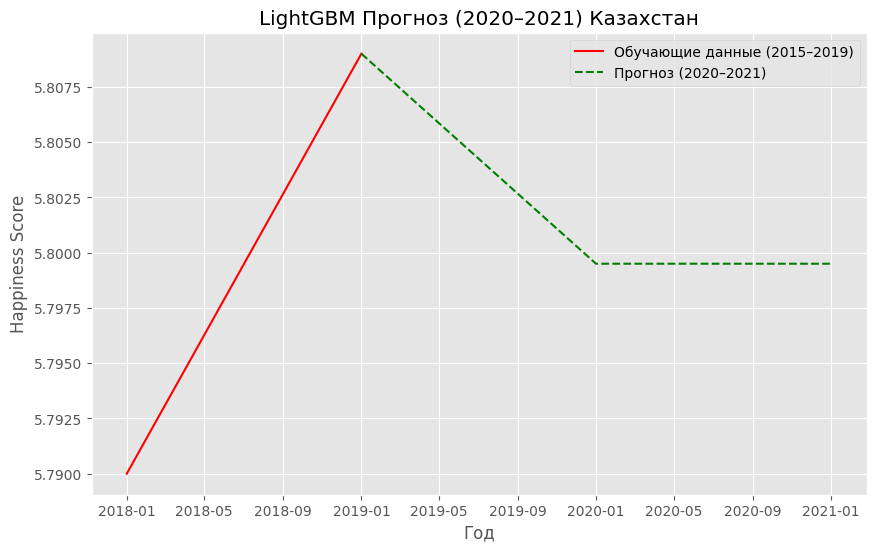

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

combined_df = combined_df[combined_df['Country'] == 'Kazakhstan'].copy()
combined_df = combined_df.sort_values('ds')

combined_df['lag_1'] = combined_df['Score'].shift(1)
combined_df['lag_2'] = combined_df['Score'].shift(2)
combined_df['lag_3'] = combined_df['Score'].shift(3)

train_data = combined_df[combined_df['ds'].dt.year <= 2019].dropna(subset=['lag_1','lag_2','lag_3'])

X_train = train_data[['GDP', 'Health', 'Family', 'Freedom', 'lag_1', 'lag_2', 'lag_3']]
y_train = train_data['Score']

params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
train_dataset = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_dataset)

last_row = train_data.iloc[-1]
last_known_score = last_row['Score']

def extrapolate_linear(df, feature, future_years):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    lr = LinearRegression()
    lr.fit(X, y)
    future_X = np.array(future_years).reshape(-1, 1)
    return lr.predict(future_X)

future_years = [2020, 2021]
future_ds = pd.to_datetime([f"{year}-01-01" for year in future_years])

future_regressors = pd.DataFrame({'ds': future_ds})
future_regressors['GDP'] = extrapolate_linear(train_data, 'GDP', future_years)
future_regressors['Health'] = extrapolate_linear(train_data, 'Health', future_years)
future_regressors['Family'] = extrapolate_linear(train_data, 'Family', future_years)
future_regressors['Freedom'] = extrapolate_linear(train_data, 'Freedom', future_years)

lag_1 = last_row['Score']
lag_2 = last_row['lag_1']
lag_3 = last_row['lag_2']

predictions = []
pred_years = []
current_lag_1 = lag_1
current_lag_2 = lag_2
current_lag_3 = lag_3

for i, year in enumerate(future_years):
    row = future_regressors.iloc[i]
    X_future = pd.DataFrame({
        'GDP': [row['GDP']],
        'Health': [row['Health']],
        'Family': [row['Family']],
        'Freedom': [row['Freedom']],
        'lag_1': [current_lag_1],
        'lag_2': [current_lag_2],
        'lag_3': [current_lag_3]
    })

    X_future = X_future.astype(float)
    pred = model.predict(X_future)[0]
    predictions.append(pred)
    pred_years.append(year)
    
    current_lag_1, current_lag_2, current_lag_3 = pred, current_lag_1, current_lag_2

smooth_df = pd.DataFrame({
    'ds': [pd.Timestamp('2019-01-01')] + list(future_ds),
    'Score': [last_known_score] + predictions
})

plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['Score'], label='Обучающие данные (2015–2019)', color='red')
plt.plot(smooth_df['ds'], smooth_df['Score'], label='Прогноз (2020–2021)', linestyle='--', color='green')

plt.title('LightGBM Прогноз (2020–2021) Казахстан')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


19:44:30 - cmdstanpy - INFO - Chain [1] start processing
19:44:34 - cmdstanpy - INFO - Chain [1] done processing


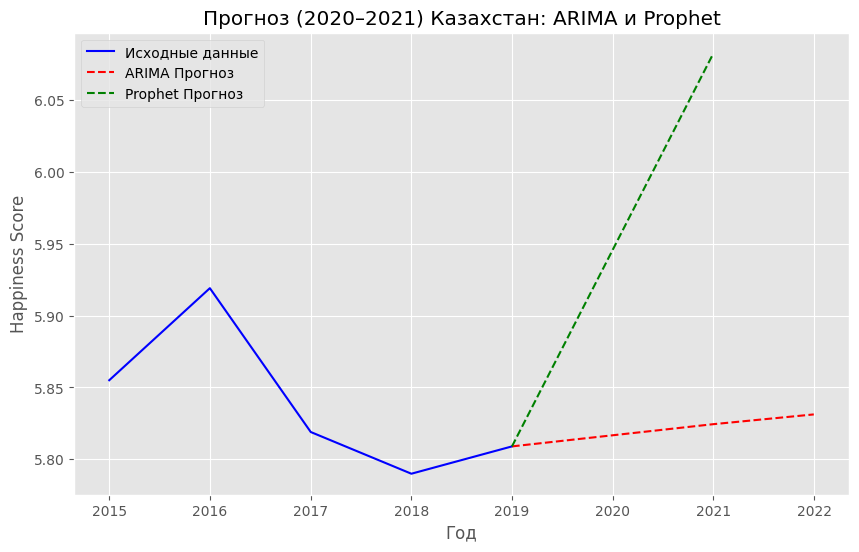

In [43]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = combined_df[combined_df['Country'] == 'Kazakhstan'].copy()
df['ds'] = pd.to_datetime(df['Year'], format='%Y')  # Создаем временной столбец
df = df.sort_values('ds')

train_df = df[df['ds'].dt.year <= 2019]
test_df = df[(df['ds'].dt.year >= 2020) & (df['ds'].dt.year <= 2021)]

y = train_df.set_index('ds')['Score']

model_arima = ARIMA(y, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

arima_forecast = model_arima_fit.forecast(steps=2)
future_dates_arima = pd.date_range(start=train_df['ds'].iloc[-1] + pd.DateOffset(years=1), periods=2, freq='Y')
arima_df = pd.DataFrame({'ds': future_dates_arima, 'Score': arima_forecast.values})

prophet_data = train_df[['ds', 'Score']].rename(columns={'Score': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_data)

future_prophet = model_prophet.make_future_dataframe(periods=2, freq='Y')
prophet_forecast = model_prophet.predict(future_prophet)
prophet_pred = prophet_forecast[future_prophet['ds'].dt.year.isin([2020, 2021])][['ds', 'yhat']]

plt.figure(figsize=(10, 6))

plt.plot(df['ds'], df['Score'], label='Исходные данные', color='blue')

arima_plot_df = pd.concat([train_df[['ds', 'Score']].iloc[-1:], arima_df], ignore_index=True)
plt.plot(arima_plot_df['ds'], arima_plot_df['Score'], label='ARIMA Прогноз', linestyle='--', color='red')

prophet_plot_df = pd.concat([train_df[['ds', 'Score']].iloc[-1:].rename(columns={'Score': 'y'}),
                             prophet_pred.rename(columns={'yhat': 'y'})], ignore_index=True)
plt.plot(prophet_plot_df['ds'], prophet_plot_df['y'], label='Prophet Прогноз', linestyle='--', color='green')

plt.title('Прогноз (2020–2021) Казахстан: ARIMA и Prophet')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

prophet_data = train_df[['ds', 'Score']].rename(columns={'Score': 'y'})

prophet_data['cap'] = 6.5 
prophet_data['floor'] = 5.5  

model_prophet = Prophet(growth='logistic', changepoint_prior_scale=0.05) 
model_prophet.fit(prophet_data)

future_prophet = model_prophet.make_future_dataframe(periods=2, freq='Y')
future_prophet['cap'] = 6.5 
future_prophet['floor'] = 5.5  

prophet_forecast = model_prophet.predict(future_prophet)

prophet_pred = prophet_forecast[prophet_forecast['ds'].dt.year.isin([2020, 2021])][['ds', 'yhat']]

plt.figure(figsize=(10, 6))

plt.plot(df['ds'], df['Score'], label='Исходные данные', color='blue')

arima_plot_df = pd.concat([last_train_point, arima_df], ignore_index=True)
plt.plot(arima_plot_df['ds'], arima_plot_df['Score'], label='ARIMA Прогноз', linestyle='--', color='red')

prophet_plot_df = pd.concat([last_train_point.rename(columns={'Score': 'y'}), prophet_pred.rename(columns={'yhat': 'y'})], ignore_index=True)
plt.plot(prophet_plot_df['ds'], prophet_plot_df['y'], label='Prophet Прогноз', linestyle='--', color='green')

plt.title('Прогноз (2020–2021) Казахстан: ARIMA и Prophet с логистическим ростом')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt

df = df.sort_values('ds')

train_df = df[df['ds'].dt.year <= 2019]


y = train_df.set_index('ds')['Score']


train_df['cap'] = 6.5  
train_df['floor'] = 5.5  

prophet_data = train_df[['ds', 'Score', 'cap', 'floor']].rename(columns={'Score': 'y'})

model_prophet = Prophet(growth='logistic', interval_width=0.95, weekly_seasonality=False, yearly_seasonality=True)
model_prophet.fit(prophet_data)

future_prophet = model_prophet.make_future_dataframe(periods=2, freq='Y')
future_prophet['cap'] = 6.5  # Добавляем границы для роста в будущем
future_prophet['floor'] = 5.5

prophet_forecast = model_prophet.predict(future_prophet)

model_prophet.plot(prophet_forecast)
plt.title('Prophet Прогноз с логистическим ростом')
plt.show()


# prophet_data = train_df[['ds', 'Score']].rename(columns={'Score': 'y'})

# model_prophet = Prophet(interval_width=0.95)  # 95% доверительный интервал
# model_prophet.fit(prophet_data)

# future_prophet = model_prophet.make_future_dataframe(periods=2, freq='Y')
# prophet_forecast = model_prophet.predict(future_prophet)

# prophet_forecast содержит колонки yhat (прогноз), yhat_lower, yhat_upper
# print("Prophet Прогноз:")
# print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2))

# model_prophet.plot(prophet_forecast)
# plt.title('Prophet Прогноз на 2 года')
# plt.xlabel('Год')
# plt.ylabel('Score')
# plt.show()

model_prophet.plot_components(prophet_forecast)
plt.show()

# test_df = df[(df['ds'].dt.year >= 2020) & (df['ds'].dt.year <= 2021)]
# y_test = test_df['Score'].values
# y_pred_arima = arima_forecast.values
# y_pred_prophet = prophet_forecast[prophet_forecast['ds'].isin(test_df['ds'])]['yhat'].values

# from sklearn.metrics import mean_squared_error
# mse_arima = mean_squared_error(y_test, y_pred_arima)
# mse_prophet = mean_squared_error(y_test, y_pred_prophet)
# print("ARIMA MSE:", mse_arima)
# print("Prophet MSE:", mse_prophet)


In [ ]:
future_prophet = model_prophet.make_future_dataframe(periods=2, freq='Y')

future_prophet = future_prophet.tail(len(future_regressors))

future_prophet['GDP'] = future_regressors['GDP'].values
future_prophet['Health'] = future_regressors['Health'].values
future_prophet['Family'] = future_regressors['Family'].values
future_prophet['Freedom'] = future_regressors['Freedom'].values


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import matplotlib.pyplot as plt

combined_df = combined_df[combined_df['Country'] == 'Kazakhstan'].copy()
combined_df = combined_df.sort_values('ds')

combined_df['lag_1'] = combined_df['Score'].shift(1)
combined_df['lag_2'] = combined_df['Score'].shift(2)
combined_df['lag_3'] = combined_df['Score'].shift(3)

train_data = combined_df[combined_df['ds'].dt.year <= 2019].dropna(subset=['lag_1','lag_2','lag_3'])

X_train = train_data[['GDP', 'Health', 'Family', 'Freedom', 'lag_1', 'lag_2', 'lag_3']]
y_train = train_data['Score']

params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'seed': 42}
train_dataset = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_dataset)

last_row = train_data.iloc[-1]
last_known_score = last_row['Score']

def extrapolate_polynomial(df, feature, future_years, degree=2):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    lin_model = LinearRegression()
    lin_model.fit(X_poly, y)
    
    future_X = poly.transform(np.array(future_years).reshape(-1, 1))
    return lin_model.predict(future_X)

future_years = [2020, 2021]
future_ds = pd.to_datetime([f"{year}-01-01" for year in future_years])

future_regressors = pd.DataFrame({'ds': future_ds})
future_regressors['GDP'] = extrapolate_polynomial(train_data, 'GDP', future_years, degree=2)
future_regressors['Health'] = extrapolate_polynomial(train_data, 'Health', future_years, degree=2)
future_regressors['Family'] = extrapolate_polynomial(train_data, 'Family', future_years, degree=2)
future_regressors['Freedom'] = extrapolate_polynomial(train_data, 'Freedom', future_years, degree=2)

current_lag_1 = last_row['Score']
current_lag_2 = last_row['lag_1']
current_lag_3 = last_row['lag_2']

predictions = []

for i, year in enumerate(future_years):
    row = future_regressors.iloc[i]
    X_future = pd.DataFrame({
        'GDP': [float(row['GDP'])],
        'Health': [float(row['Health'])],
        'Family': [float(row['Family'])],
        'Freedom': [float(row['Freedom'])],
        'lag_1': [float(current_lag_1)],
        'lag_2': [float(current_lag_2)],
        'lag_3': [float(current_lag_3)]
    })

    pred = model.predict(X_future)[0]
    predictions.append(pred)
    
    current_lag_1 = pred
    current_lag_2, current_lag_3 = current_lag_1, current_lag_2

if len(predictions) != len(future_ds):
    raise ValueError("Длины 'predictions' и 'future_ds' не совпадают!")

smooth_df = pd.DataFrame({
    'ds': [pd.Timestamp('2019-01-01')] + list(future_ds),
    'Score': [last_known_score] + predictions
})

plt.figure(figsize=(10, 6))
plt.plot(train_data['ds'], train_data['Score'], label='Обучающие данные (2015–2019)', color='red')
plt.plot(smooth_df['ds'], smooth_df['Score'], label='Прогноз (2020–2021)', linestyle='--', color='green')

plt.title('LightGBM Прогноз (2020–2021) с полиномиальной экстраполяцией')
plt.xlabel('Год')
plt.ylabel('Happiness Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("Последняя строка данных:", last_row)

print("Будущие регрессоры на 2020 и 2021:")
print(future_regressors)


In [ ]:
smooth_years = pd.date_range(start='2019-01-01', end='2021-01-01', freq='YS')
smooth_scores = [last_known_score, pred_2020, pred_2021]

smooth_df = pd.DataFrame({'ds': smooth_years, 'Score': smooth_scores})


In [ ]:
kaz_data = combined_df[combined_df['Country'] == 'Kazakhstan'].copy()


In [ ]:
import pandas as pd
import numpy as np

train_kaz = kaz_data[kaz_data['ds'].dt.year <= 2019]

last_row = train_kaz.iloc[-1]
last_score_2019 = last_row['Score']

lag_1_2020 = last_score_2019
lag_2_2020 = last_row['lag_1']
lag_3_2020 = last_row['lag_2']

def extrapolate_linear(df, feature, future_year=2020):
    temp = df[['ds', feature]].copy()
    temp['year'] = temp['ds'].dt.year
    X = temp[['year']]
    y = temp[feature]
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    lr.fit(X, y)
    return lr.predict([[future_year]])[0]

gdp_2020 = extrapolate_linear(train_kaz, 'GDP', future_year=2020)
health_2020 = extrapolate_linear(train_kaz, 'Health', future_year=2020)
family_2020 = extrapolate_linear(train_kaz, 'Family', future_year=2020)
freedom_2020 = extrapolate_linear(train_kaz, 'Freedom', future_year=2020)

X_2020 = pd.DataFrame({
    'GDP': [gdp_2020],
    'Health': [health_2020],
    'Family': [family_2020],
    'Freedom': [freedom_2020],
    'lag_1': [lag_1_2020],
    'lag_2': [lag_2_2020],
    'lag_3': [lag_3_2020]
})

X_2020 = X_2020.astype(float)  # Убедимся, что типы числовые

pred_2020 = model.predict(X_2020)[0]
print("Предсказанный Score для Казахстана в 2020 году:", pred_2020)
